<a href="https://colab.research.google.com/github/borrjo19/machine-learning-for-trading/blob/main/Project_and_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joshua Borrett - Project

# Aims:
**Question guidelines**

• A comparison between methods consists in reporting numerical results (final function values,convergence plots) given a budget (number of iterations, epochs,...) and commenting on them.
Is there a clear winner in the comparison? Are there results that are surprising to you?


• When details of the implementation are left open, you should choose settings that allow for fast convergence, or that look informative to you. Your comments should reflect these choices.

• The goal of testing several values of an hyperparameter (e.g. a constant step size) is to assess the robustness of a given method with respect to this hyperparameter. Are the results sensitive to changes in the value of the hyperparameter? Can you identify regimes of values that yield similar results (such as the large batch and mini-batch regimes for the batch size in stochastic
gradient)?

We will compare our methods mainly using the nb of iterations as a control as it is easier to programme compared to using the number of epochs which is variable on the batch size when using stochastic methods. However when easy to do so we will also look at comparison via epochs. As a reminder:

$\text{Epoch} = \frac{\text{iterations x batch size}}{\text{size of data}}$

The idea behind the use of Epochs is that for stochastic methods where we take often a subsample of the data to use in calculations in order to accelerate the process or alleviate the compuatational complexity, we can run a larger number of iterations for the same budget - so in order to fairly compare stochastic and determinsitic descent methods it is fair to use a different number of iterations for each method depending on the chosen batchsize.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# **Question 1: Selection of a Training Dataset for Binary Classification**

We select a training dataset for **binary classification** in the following form:

$
\{(a_i, y_i)\}_{i=1}^{n}, \quad \text{where } a_i \in \mathbb{R}^d \text{ and } y_i \in \{0,1\}.
$

Comment briefly on the dataset - what does the correlation matrix look like etc...



In [3]:
X = pd.read_csv(r"/content/ijcnn1.val")
print(X)

      -1.0 6:1 11:0.282038 12:0.468414 13:0.107345 14:-0.286444 15:0.073193 16:0.107299 17:0.401498 18:-0.122181 19:-0.245745 20:0.293809 21:-0.020231 22:-0.086821
0      -1.0 7:1 11:0.278202 12:0.468414 13:-0.286444 ...                                                                                                           
1      -1.0 8:1 11:0.282788 12:0.468414 13:0.073193 1...                                                                                                           
2      -1.0 9:1 11:0.282473 12:0.468414 13:0.107299 1...                                                                                                           
3      1.0 10:1 11:0.281117 12:0.468414 13:0.401498 1...                                                                                                           
4      -1.0 1:1 11:0.277633 12:0.468414 13:-0.122181 ...                                                                                                           
...             

<font size = "4">We can see that the dataset is currently in LIBSVM form and has been imported into a single column vector - we must put this in useable form, we can also see that the correspoding y vector is in (-1,1) and not (0,1) as we need so we must change that too:

In [4]:
labels = []
rows = []
cols = []
vals = []

max_index = 0

with open(r'/content/ijcnn1.val', 'r') as f:
    for i, line in enumerate(f):
        parts = line.strip().split()
        for p in parts[1:]:  # skip the label
            index_str, value_str = p.split(":")
            index = int(index_str)
            max_index = max(max_index, index)


with open(r'/content/ijcnn1.val', 'r') as f:
    row_num = 0
    for line in f:
        parts = line.strip().split()
        y_val = float(parts[0])
        labels.append(y_val)


        for p in parts[1:]:
            index_str, value_str = p.split(":")
            index = int(index_str) - 1
            value = float(value_str)
            rows.append(row_num)
            cols.append(index)
            vals.append(value)

        row_num += 1


from scipy.sparse import csr_matrix
X = csr_matrix((vals, (rows, cols)), shape=(row_num, max_index))
y = np.array(labels)
X=X.toarray()
y = (y+1)/2
y = y[:5000]
X = X[:5000,:]
y_array = y
X_array = X
print(X)
print(y)

print("X dimensions", X.shape)
print("y dimensions" ,y.shape)
print("number of points in class 1 =", sum(y))

[[ 0.        0.        0.       ...  0.293809 -0.020231 -0.086821]
 [ 0.        0.        0.       ... -0.020231 -0.086821 -0.222904]
 [ 0.        0.        0.       ... -0.086821 -0.222904  0.243209]
 ...
 [ 0.        0.        1.       ...  0.266868 -0.122001 -0.225309]
 [ 0.        0.        0.       ... -0.122001 -0.225309  0.191034]
 [ 0.        0.        0.       ... -0.225309  0.191034  0.445905]]
[0. 0. 0. ... 0. 0. 0.]
X dimensions (5000, 22)
y dimensions (5000,)
number of points in class 1 = 458.0


Here we have the dataset labelled X, that we have formed into a numpy array for ease of manipulation, and the classification which is now in 0,1 is labelled y. We can see that X is seemingly quite sparse, and that the majority of the data is of class 0. We only have 22 covariates so hopefully 458 class 1 elements should be sufficient for useful results.

(N.B - having also tried other datasets alot of the proposed options are also sparse and/or heavily weighted to one class)

Now we check for na values in the dataset

In [5]:
X_df = pd.DataFrame(X_array)
y_df = pd.DataFrame(y_array)

if True in X_df.isna():
  print("There are missing values in X_sparse")
else:
  print("Thats lucky...")

Thats lucky...


there are no na values :)

We can implement a correlation matrix

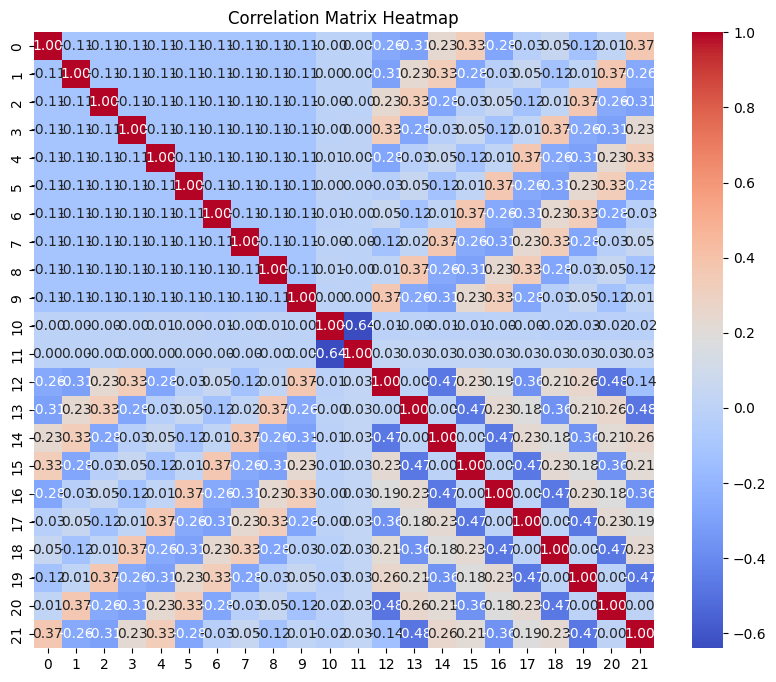

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

There are a few non diagonal correlations but other than 11-10, there is weak correlation between covariates so this should be ok

In [7]:
summary_stats = X_df.describe()
print(summary_stats)

               0           1           2           3           4           5   \
count  5000.00000  5000.00000  5000.00000  5000.00000  5000.00000  5000.00000   
mean      0.10000     0.10000     0.10000     0.10000     0.10000     0.10000   
std       0.30003     0.30003     0.30003     0.30003     0.30003     0.30003   
min       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000   
25%       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000   
50%       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000   
75%       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000   
max       1.00000     1.00000     1.00000     1.00000     1.00000     1.00000   

               6           7           8           9   ...           12  \
count  5000.00000  5000.00000  5000.00000  5000.00000  ...  5000.000000   
mean      0.10000     0.10000     0.10000     0.10000  ...    -0.002965   
std       0.30003     0.30003     0.30003    

The 1st 10 columns are strange std = 0.3, but 1-3rd quantiles are all 0?

Have a better look at the distributions of the dataset

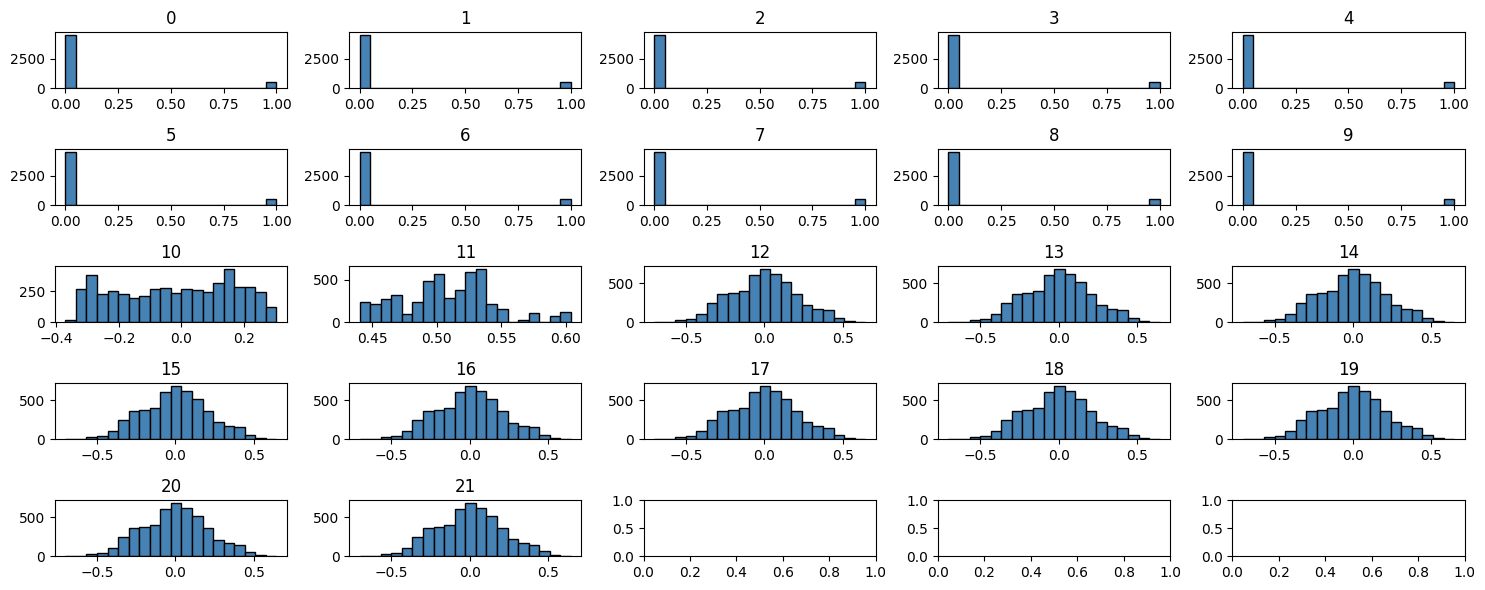

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

columns_to_plot = X_df.columns[:]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 6))

for i, col in enumerate(columns_to_plot):
    ax = axs[i // 5, i % 5]

    ax.hist(X_df[col].dropna(), bins=20, color='steelblue', edgecolor='black')
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [9]:
#these codes count the number of 1's in the 1st 10 columns and in the 10th column

s = 0
for j in range(0,10):
  for i in X_df.iloc[:,j]:
    if i == 1:
      s += 1
print(s)

s = 0
for i in X_df.iloc[:,9]:
  if i != 0:
    s += 1
print(s)


5000
500


**IMPORTANT** From these 2 plots we deduce that the first 10 columns are a probably1-hot encoding of a 10 - class variable which means that a 1 in column j, for j in [0,9] means that the point belong to class j+1 - this explains the sparsity in our dataset. We can also see that there are exactly equal proportions of each class represented in the data which is very useful.

The other variables are all either between 0-1 or roughly -0.5,0.5 which is useful as it means they are all roughly of the same scale which can be helpful in stability of predictions. Demonstartion: imagine one column, i, takes values around 100, and another of order 10^-1 in a linear model s.t Y_hat = X*B_hat. When predicting a new value based on a new datapoint, a small error in the B_hat_i corresponding to column i, will be much more costly than a small error in the B_j. Having the values of the same magnitude reduces this variance.


# **Question 2 Optimisation Problems**

<p>
In this project, we consider a <b>binary classification problem</b> based on the dataset from Question 1, of the form:
</p>
$
\min_{x \in \mathbb{R}^d} f(x) := \frac{1}{n} \sum_{i=1}^{n} f_i(x),
$
$
f_i(x) := \left( y_i - \frac{1}{1 + \exp(-a_i^T x)} \right)^2.
$

<p>
This problem is <b>nonconvex</b> in general. The function
$
t \mapsto \frac{1}{1+\exp(-t)}
$
is called the <b>sigmoid function</b>.
</p>

<p>
For any \( i = 1, \dots, n \), the gradient of \( f_i(x) \) is given by:
</p>

$
\nabla f_i(x) = - \frac{2 a_i \exp(a_i^T x) \left[ \exp(a_i^T x)(y_i - 1) + y_i \right]}{(1 + \exp(a_i^T x))^3}.
$

<h2>Gradient Computation Using Autograd</h2>

<p>
Given a data point \( (a_i, y_i) \) from your dataset, use the <b>Autograd framework</b> described in the second lab session to implement a code for the function \( f_i(x) \) that enables computing \( \nabla f_i(x) \) for any \( x \) through <b>automatic differentiation</b>.
</p>

<p>
Validate your implementation using the explicit formula:
</p>

$$
\nabla f_i(x) = -\frac{2 \exp(a_i^T x) \left( \exp(a_i^T x)(y_i - 1) + y_i \right)}{(1 + \exp(a_i^T x))^3} a_i.
$$


We have chosen a_1, and y_1.

Here is the AutoGrad method:

In [10]:
import pandas as pd
import torch
from numpy import arange

#must convert y to array or we get some indexing error
a_1 = X_df.iloc[1].values
a_1 = np.array(a_1)
y_1 = y[1]
y_1 = np.array(y_1)

a_1 = torch.tensor(a_1, requires_grad=True)
y_1 = torch.tensor(y_1, requires_grad=True)


x = torch.tensor(np.zeros(22), requires_grad=True)
#test value = (1,1,...,1)

sigmoid = 1 / (1 + torch.exp(-torch.dot(a_1, x)))


f_i = (y_1 - sigmoid) ** 2


f_i.backward()


autograd_gradient = x.grad
print("Autograd Gradient:", autograd_gradient)

Autograd Gradient: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2500,  0.0000,
         0.0000,  0.0000,  0.0696,  0.1171, -0.0716,  0.0183,  0.0268,  0.1004,
        -0.0305, -0.0614,  0.0735, -0.0051, -0.0217, -0.0557],
       dtype=torch.float64)


Here is the exact method both taken from TP2

In [11]:
from sklearn.metrics import mean_squared_error

exp_term = torch.exp(torch.dot(a_1, x))
sigmoid_value = 1 / (1 + exp_term)
a = -2 * exp_term * (y_1 - sigmoid_value)
b = (1 + exp_term) ** 2
grad_fi = (a / b) * a_1
print("Exact Gradient Calc:", grad_fi)

print("MSE between the 2 methods =", mean_squared_error(autograd_gradient.detach().numpy(), grad_fi.detach().numpy()))

Exact Gradient Calc: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2500,  0.0000,
         0.0000,  0.0000,  0.0696,  0.1171, -0.0716,  0.0183,  0.0268,  0.1004,
        -0.0305, -0.0614,  0.0735, -0.0051, -0.0217, -0.0557],
       dtype=torch.float64, grad_fn=<MulBackward0>)
MSE between the 2 methods = 0.0


**Conclusion:** both methods return the same value - validating our implementation of AutoGrad

# Q3:First Order Algorithms Gradient Descent on (1)

Question 3 Adapt the code of gradient descent provided during the lab sessions (or use your own
implementation) to run it on problem (1).

• What convergence rate is expected for gradient descent on this problem? Do you observe this rate empirically?

• Can you find a good constant value for the stepsize?

<p style="font-size:18px;">
A function $ f(x) $ is L-smooth if its gradient $\nabla f(x)$ is L-Lipschitz continuous, meaning there exists a constant $ L > 0 $ such that:
</p>

$$
\|\nabla f(x) - \nabla f(y)\| \leq L \|x - y\|, \quad \forall x, y.
$$


<p style="font-size:18px;">
To decide whether such an \( L \) exists, we can look at the Hessian matrix. In this case, the Hessian is very difficult to compute and bound directly.

However, if we assume \( a_i \) and \( x \) are scalars, we find that the second derivative is bounded, suggesting that the Hessian is also bounded.
</p>

<p style="font-size:18px;">
In \( \mathbb{R} \), we do not need to calculate the second derivative explicitly to know that it is bounded. Considering the general shape of the sigmoid function, we know:
</p>

<ul style="font-size:18px;">
  <li> \( f' \) is positive and approaches \( 0 \) at the extremes.</li>
  <li> Since \( f' \) is continuous and tends to \( 0 \), \( f'' \) must also tend to \( 0 \) at the extremes.</li>
  <li> By the Mean Value Theorem, \( f'' \) must attain a maximum in absolute value, meaning it is bounded.</li>
</ul>

<p style="font-size:18px;">
By the same reasoning, we expect the eigenvalues of the Hessian to also be bounded, which implies that \( f(x) \) is L-smooth, with L the largerst eigenavalue.
</p>

We could think about using AutoGrad/Exact differentiation to give an exact calculation for the Hessian for our dataset and then find the largest eigenvalue computationally - unfortunataly every time i have tried I have recieved a runtime error that causes VSCode/Colab to crash and restart kernal due to having to manipulate such a large matrix  

Given the non-convexity of this function, we know that we cannot have guarenteed convergence to a gloabl minima using the GD Method, however we have the following theorem on convergence to first order critical points:

<p>
Let \( T \in \mathbb{N} \) be fixed. We consider the following algorithm:
</p>

<ol style="font-size:18px;">
    <li>Run \( T \) steps of gradient descent, which defines a sequence:</li>
</ol>

$$
(x_0, x_1, \dots, x_T).
$$

<ol start="2" style="font-size:18px;">
    <li>Compute \( T_{\min} = \arg\min_{0 \leq t \leq T} \|\nabla f(x_t)\| \) and define \( \tilde{x}_T = x_{T_{\min}} \).</li>
</ol>

<ol start="3" style="font-size:18px;">
    <li>Return \( \tilde{x}_T \).</li>
</ol>

<p style="font-size:18px;">
Then, we obtain the bound:
</p>

$$
\|\nabla f(\tilde{x}_T)\| \leq \sqrt{\frac{2L(f(x_0) - f(x^*))}{T}}.
$$

<p style="font-size:18px;">
We say that \( \tilde{x}_T \) is an \( O(1/\sqrt{T}) \)-approximate first-order critical point.
</p>

In [12]:
####Using the TP the implementation of GD is simple, we just have to add the sigmoid function to f(x) = ||sigma(Ax)-y||
def Grad_Descent(x_init, stepsize, X_tensor, y_tensor, nb_iters=300):

    x = x_init.clone().detach().requires_grad_(True)  # Ensure x is a leaf tensor
    grad_norms = []
    losses = []

    for i in range(nb_iters):
        y_pred = torch.sigmoid(torch.mm(X_tensor, x))  # More efficient sigmoid computation
        loss = torch.mean((y_tensor - y_pred) ** 2)

        loss.backward()

        # Ensure gradient is properly accessed
        grad_norm = x.grad.norm().item()
        grad_norms.append(grad_norm)
        losses.append(loss.item())

        with torch.no_grad():
            x -= stepsize * x.grad  # Parameter update
            x.grad.zero_()  # Reset gradient

        x.requires_grad_(True)  # Ensure x stays as a leaf tensor

        if i % 10 == 0:
            print(f"Iteration {i}/{nb_iters}: Loss={loss.item():.6f}, Grad Norm={grad_norm:.6f}")

    return x.detach(), grad_norms, losses

In [13]:
X_tensor = torch.tensor(X_array, dtype = torch.float32)
y_tensor = torch.tensor(y_array, dtype = torch.float32)
x0 = torch.zeros((22,1), requires_grad=True)

In [14]:
x_gd1,grad_norms_gd1,losses_gd1 = Grad_Descent(x_init = x0, stepsize = 0.5, X_tensor = X_tensor, y_tensor = y_tensor, nb_iters=300)

Iteration 0/300: Loss=0.250000, Grad Norm=0.122300
Iteration 10/300: Loss=0.190092, Grad Norm=0.095194
Iteration 20/300: Loss=0.154391, Grad Norm=0.073292
Iteration 30/300: Loss=0.132971, Grad Norm=0.057379
Iteration 40/300: Loss=0.119570, Grad Norm=0.046008
Iteration 50/300: Loss=0.110773, Grad Norm=0.037757
Iteration 60/300: Loss=0.104736, Grad Norm=0.031624
Iteration 70/300: Loss=0.100434, Grad Norm=0.026949
Iteration 80/300: Loss=0.097267, Grad Norm=0.023302
Iteration 90/300: Loss=0.094872, Grad Norm=0.020397
Iteration 100/300: Loss=0.093019, Grad Norm=0.018041
Iteration 110/300: Loss=0.091557, Grad Norm=0.016099
Iteration 120/300: Loss=0.090385, Grad Norm=0.014477
Iteration 130/300: Loss=0.089431, Grad Norm=0.013105
Iteration 140/300: Loss=0.088645, Grad Norm=0.011933
Iteration 150/300: Loss=0.087990, Grad Norm=0.010921
Iteration 160/300: Loss=0.087439, Grad Norm=0.010040
Iteration 170/300: Loss=0.086972, Grad Norm=0.009268
Iteration 180/300: Loss=0.086573, Grad Norm=0.008586
Iter

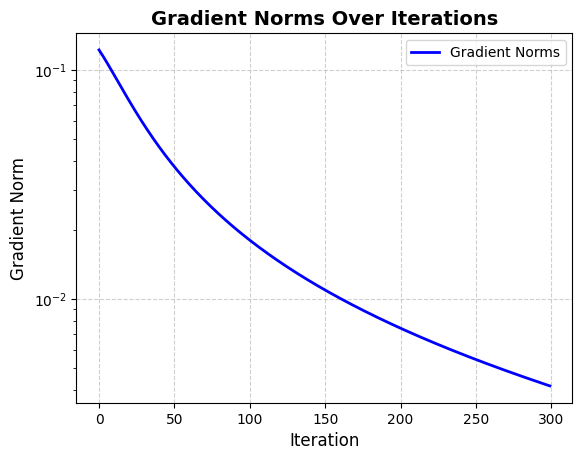

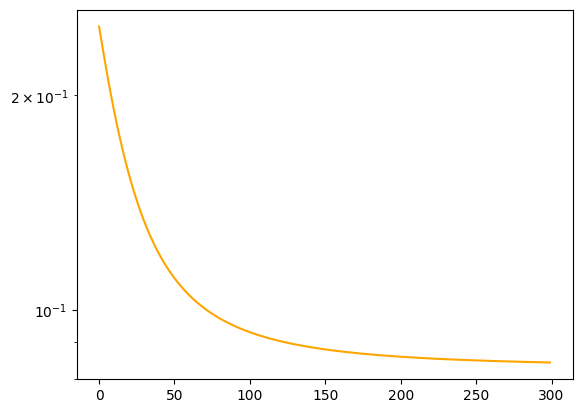

In [15]:
plt.figure()
plt.semilogy(grad_norms_gd1, linestyle='-', linewidth=2, markersize=5, color='b', label='Gradient Norms')

plt.title("Gradient Norms Over Iterations", fontsize=14, fontweight='bold')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Gradient Norm", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
plt.semilogy(losses_gd1, linestyle = '-', color = "orange", label = "function value")
plt.show()

**IMPORTANT** This result is quite surprising as it actually supports what we the theorem says. Plotting the Gradient norms on a log scale we see that in 100 iterations we decrease roughy by a factor 10, from 10e-1 to c.10e-2, which is supportive of the O(1/sqrt(N)) rate!

Furthermore the value of the objective function is also decreasing

We will now implement a gridsearch algorithm over several values of stepsize to find the optimal.

In [16]:
def grid_search_stepsize(x_init, X_tensor, y_tensor, step_sizes, nb_iters=100):
    """
    Performs a grid search over step sizes to find the optimal learning rate.

    Parameters:
        x_init: Initial tensor for parameters.
        X_tensor: Feature tensor.
        y_tensor: Target tensor.
        step_sizes: List or array of step sizes to try.
        nb_iters: Number of iterations for gradient descent.

    Returns:
        best_step_size: The step size that achieves the lowest final loss.
        results: Dictionary containing step sizes and corresponding final losses.
    """
    results = {}
    best_step_size = None
    best_loss = float('inf')

    for step_size in step_sizes:
        print(f"Testing step size: {step_size:.6f}")

        # Run gradient descent with the current step size
        x_opt, _, losses = Grad_Descent(x_init, step_size, X_tensor, y_tensor, nb_iters)

        final_loss = losses[-1]  # Take the last loss value

        results[step_size] = final_loss

        # Update best step size if the new loss is lower
        if final_loss < best_loss:
            best_loss = final_loss
            best_step_size = step_size

    return best_step_size, results

# Example Usage:
step_sizes = [60,62]
x0 = torch.zeros((22, 1))

best_step_size, results = grid_search_stepsize(x0, X_tensor, y_tensor, step_sizes)

# Print best step size
print(f"\nBest step size: {best_step_size}")

# Print all results
for step, loss in results.items():
    print(f"Step size: {step:.6f}, Final Loss: {loss:.6f}")

Testing step size: 60.000000
Iteration 0/100: Loss=0.250000, Grad Norm=0.122300
Iteration 10/100: Loss=0.088488, Grad Norm=0.001588
Iteration 20/100: Loss=0.086271, Grad Norm=0.002261
Iteration 30/100: Loss=0.083603, Grad Norm=0.001341
Iteration 40/100: Loss=0.083308, Grad Norm=0.000232
Iteration 50/100: Loss=0.083286, Grad Norm=0.000161
Iteration 60/100: Loss=0.083274, Grad Norm=0.000119
Iteration 70/100: Loss=0.083268, Grad Norm=0.000088
Iteration 80/100: Loss=0.083264, Grad Norm=0.000066
Iteration 90/100: Loss=0.083262, Grad Norm=0.000049
Testing step size: 62.000000
Iteration 0/100: Loss=0.250000, Grad Norm=0.122300
Iteration 10/100: Loss=0.088948, Grad Norm=0.001390
Iteration 20/100: Loss=0.087160, Grad Norm=0.002058
Iteration 30/100: Loss=0.084111, Grad Norm=0.001937
Iteration 40/100: Loss=0.083322, Grad Norm=0.000303
Iteration 50/100: Loss=0.083291, Grad Norm=0.000176
Iteration 60/100: Loss=0.083276, Grad Norm=0.000129
Iteration 70/100: Loss=0.083269, Grad Norm=0.000094
Iteratio

***DUE TO THE TIME TO RUN THIS FUNCTION I RAN IT SEVERAL TIMES CHANGING THE INPUTS MANUALLY AS IT IS FASTER THAN ENTERING A LARGE VECTOR FOR GRIDSEARCH***

We fin that 60 is the best stepsize which is larger than expected, however one explanation is that gradients are often atleast 1 order of magnitude smaller than the input data, so in order to get a small change in x since the gradients are small we need a comparatively large stepsize?

Perhaps it is also due to the sparsity of our data matrix?

Iteration 0/300: Loss=0.250000, Grad Norm=0.122300
Iteration 10/300: Loss=0.088488, Grad Norm=0.001588
Iteration 20/300: Loss=0.086271, Grad Norm=0.002261
Iteration 30/300: Loss=0.083603, Grad Norm=0.001341
Iteration 40/300: Loss=0.083308, Grad Norm=0.000232
Iteration 50/300: Loss=0.083286, Grad Norm=0.000161
Iteration 60/300: Loss=0.083274, Grad Norm=0.000119
Iteration 70/300: Loss=0.083268, Grad Norm=0.000088
Iteration 80/300: Loss=0.083264, Grad Norm=0.000066
Iteration 90/300: Loss=0.083262, Grad Norm=0.000049
Iteration 100/300: Loss=0.083261, Grad Norm=0.000038
Iteration 110/300: Loss=0.083260, Grad Norm=0.000030
Iteration 120/300: Loss=0.083260, Grad Norm=0.000025
Iteration 130/300: Loss=0.083259, Grad Norm=0.000021
Iteration 140/300: Loss=0.083259, Grad Norm=0.000019
Iteration 150/300: Loss=0.083259, Grad Norm=0.000018
Iteration 160/300: Loss=0.083259, Grad Norm=0.000017
Iteration 170/300: Loss=0.083259, Grad Norm=0.000017
Iteration 180/300: Loss=0.083259, Grad Norm=0.000016
Iter

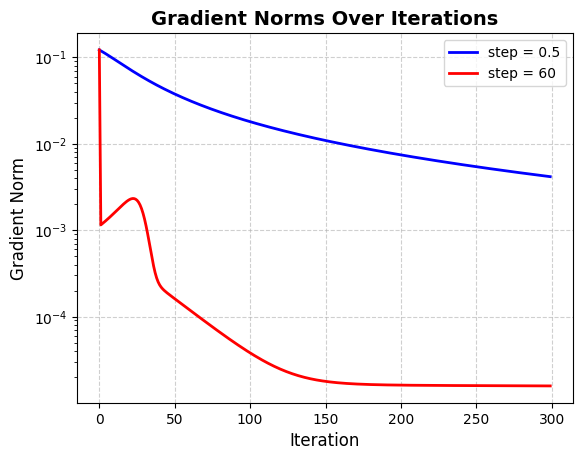

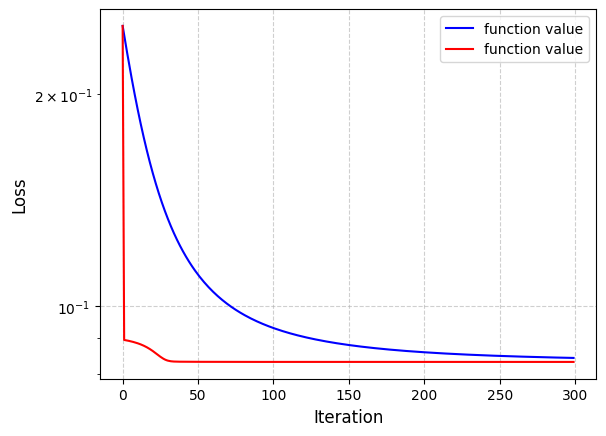

In [17]:
###now time to implement GD for this stepsize

x_gd_opt,grad_norms_gd_opt,losses_gd_opt = Grad_Descent(x_init = x0, stepsize = 60, X_tensor = X_tensor, y_tensor = y_tensor, nb_iters=300)

plt.figure()
plt.semilogy(grad_norms_gd1, linestyle='-', linewidth=2, markersize=5, color='b', label='step = 0.5')
plt.semilogy(grad_norms_gd_opt, linestyle='-', linewidth=2, markersize=5, color='r', label='step = 60')
plt.title("Gradient Norms Over Iterations", fontsize=14, fontweight='bold')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Gradient Norm", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.semilogy(losses_gd1, linestyle = '-', color = "blue", label = "function value")
plt.semilogy(losses_gd_opt, linestyle = '-', color = "red", label = "function value")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()

In conclusion we have observed the expected rate of convergence within the first 300 interations, and a good choice of constant step size found by gridsearch is 60

# **Q4: Stochastic Gradiant**

Adapt the code of batch stochastic gradient provided during the third lab session (or use your own implementation) to compare gradient descent and stochastic gradient on problem (1).

• Are your results consistent with what the theory predicts?

• Can you find a good constant stepsize choice for stochastic gradient? What appears to be the best value for the batch size on this problem?

In [18]:
def Stochastic_grad_descent(x_init, stepsize, X_df, y_df, batch_size, nb_iters):
    # Ensure input dimensions
    n, d = X_df.shape

    # Initialize parameters
    x = x_init.clone().detach().requires_grad_(True)

    # Storage lists for analysis
    grad_norms = []
    losses = []

    # SGD Loop
    for i in range(nb_iters):
        # Random batch selection
        indices = torch.randperm(n)[:batch_size]  # Random batch indices
        A_batch = X_df.iloc[indices.numpy()].values  # Convert batch to numpy
        y_batch = y_df.iloc[indices.numpy()].values

        # Convert batch to PyTorch tensors
        A_batch = torch.tensor(A_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32).view(-1, 1)

        # Compute loss on batch
        loss = ((y_batch - (1 / (1 + torch.exp(-torch.matmul(A_batch, x))))) ** 2).mean()

        # Compute gradient
        loss.backward()

        # Store iteration results
        grad_norms.append(torch.norm(x.grad).detach().item())
        losses.append(loss.detach().item())

        # Parameter update with gradient descent
        with torch.no_grad():
            x -= stepsize * x.grad
            x.grad.zero_()  # Reset gradient

        # Print progress every 10 iterations
        if i % 10 == 0:
            print(f"Iteration {i}/{nb_iters}: Loss = {loss.item():.6f}, Grad Norm = {grad_norms[-1]:.6f}")

    return x.detach(), grad_norms, losses

In [19]:
x_sgd, grad_norms_sgd, losses_sgd = Stochastic_grad_descent(x0, 60, X_df, y_df, 2500, 300)

Iteration 0/300: Loss = 0.250000, Grad Norm = 0.120840
Iteration 10/300: Loss = 0.085896, Grad Norm = 0.005770
Iteration 20/300: Loss = 0.051608, Grad Norm = 0.004920
Iteration 30/300: Loss = 0.039462, Grad Norm = 0.003257
Iteration 40/300: Loss = 0.038940, Grad Norm = 0.002446
Iteration 50/300: Loss = 0.032980, Grad Norm = 0.002049
Iteration 60/300: Loss = 0.035603, Grad Norm = 0.002147
Iteration 70/300: Loss = 0.034243, Grad Norm = 0.001692
Iteration 80/300: Loss = 0.034347, Grad Norm = 0.001946
Iteration 90/300: Loss = 0.033916, Grad Norm = 0.001516
Iteration 100/300: Loss = 0.029677, Grad Norm = 0.002035
Iteration 110/300: Loss = 0.030011, Grad Norm = 0.001904
Iteration 120/300: Loss = 0.031708, Grad Norm = 0.001108
Iteration 130/300: Loss = 0.033551, Grad Norm = 0.001485
Iteration 140/300: Loss = 0.032298, Grad Norm = 0.001517
Iteration 150/300: Loss = 0.032005, Grad Norm = 0.001284
Iteration 160/300: Loss = 0.030891, Grad Norm = 0.001598
Iteration 170/300: Loss = 0.030691, Grad N

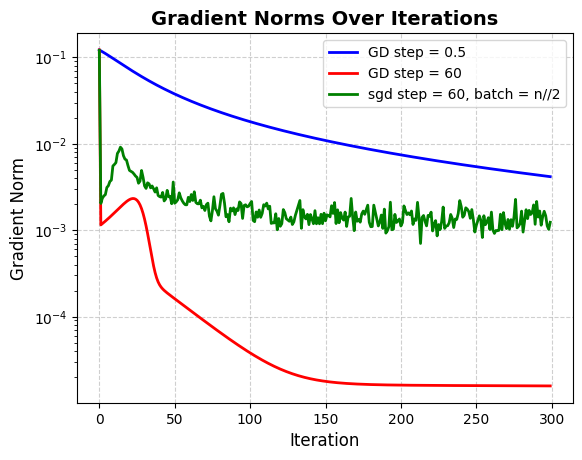

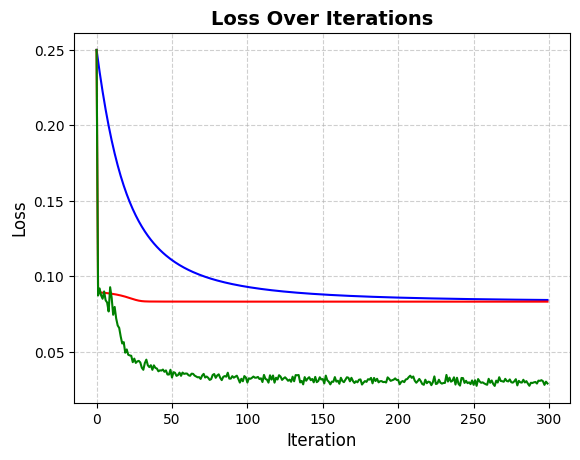

In [20]:
plt.figure()
plt.semilogy(grad_norms_gd1, linestyle='-', linewidth=2, markersize=5, color='b', label='GD step = 0.5')
plt.semilogy(grad_norms_gd_opt, linestyle='-', linewidth=2, markersize=5, color='r', label='GD step = 60')
plt.semilogy(grad_norms_sgd, linestyle='-', linewidth=2, markersize=5, color='g', label='sgd step = 60, batch = n//2')
plt.title("Gradient Norms Over Iterations", fontsize=14, fontweight='bold')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Gradient Norm", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.plot(losses_gd1, linestyle = '-', color = "blue", label = "gd value")
plt.plot(losses_gd_opt, linestyle = '-', color = "red", label = "gd opt value")
plt.plot(losses_sgd, linestyle = '-', color = "green", label = "sgd value")
plt.title("Loss Over Iterations", fontsize=14, fontweight='bold')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

Now we implement the same same gridsearch idea for the SGD

In [21]:
def stochastic_grid_search_stepsize(x_init, X_tensor, y_tensor, step_sizes, batch_size, nb_iters=100):

    results = {}
    all_losses = {}
    all_grad_norms = {}
    best_step_size = None
    best_loss = float('inf')

    for step_size in step_sizes:
        print(f"Testing step size: {step_size:.6f}")

        # Run SGD with the current step size
        x_sgd_opt, grad_norms, losses = Stochastic_grad_descent(x_init, step_size, X_df, y_df, batch_size, nb_iters)

        final_loss = losses[-1]  # Take the last loss value
        results[step_size] = final_loss
        all_losses[step_size] = losses
        all_grad_norms[step_size] = grad_norms

        # Update best step size if the new loss is lower
        if final_loss < best_loss:
            best_loss = final_loss
            best_step_size = step_size

    return best_step_size, results, all_losses, all_grad_norms

# Example Usage:
step_sizes = [ 0.1, 1, 10,50]   # Step sizes to test
batch_size = 1000  # Mini-batch size
nb_iters = 300  # Number of iterations

# Run Stochastic Grid Search
best_step_size, results_stochastic, all_losses, all_grad_norms = stochastic_grid_search_stepsize(
    x0, X_tensor, y_tensor, step_sizes, batch_size, nb_iters
)

# Print best step size
#print(f"\nBest step size: {best_step_size}")

# Print all results
#for step, loss in results_stochastic.items():
#    print(f"Step size: {step:.6f}, Final Loss: {loss:.6f}")


Testing step size: 0.100000
Iteration 0/300: Loss = 0.250000, Grad Norm = 0.122293
Iteration 10/300: Loss = 0.235294, Grad Norm = 0.118185
Iteration 20/300: Loss = 0.222284, Grad Norm = 0.111800
Iteration 30/300: Loss = 0.211820, Grad Norm = 0.102194
Iteration 40/300: Loss = 0.199105, Grad Norm = 0.102137
Iteration 50/300: Loss = 0.191884, Grad Norm = 0.092423
Iteration 60/300: Loss = 0.180160, Grad Norm = 0.092333
Iteration 70/300: Loss = 0.169711, Grad Norm = 0.090922
Iteration 80/300: Loss = 0.163276, Grad Norm = 0.085174
Iteration 90/300: Loss = 0.158801, Grad Norm = 0.078734
Iteration 100/300: Loss = 0.153051, Grad Norm = 0.074879
Iteration 110/300: Loss = 0.150663, Grad Norm = 0.068506
Iteration 120/300: Loss = 0.145779, Grad Norm = 0.065420
Iteration 130/300: Loss = 0.137572, Grad Norm = 0.065045
Iteration 140/300: Loss = 0.134179, Grad Norm = 0.061916
Iteration 150/300: Loss = 0.127907, Grad Norm = 0.060635
Iteration 160/300: Loss = 0.128846, Grad Norm = 0.055839
Iteration 170/

***Study the effect of step size on SGD***


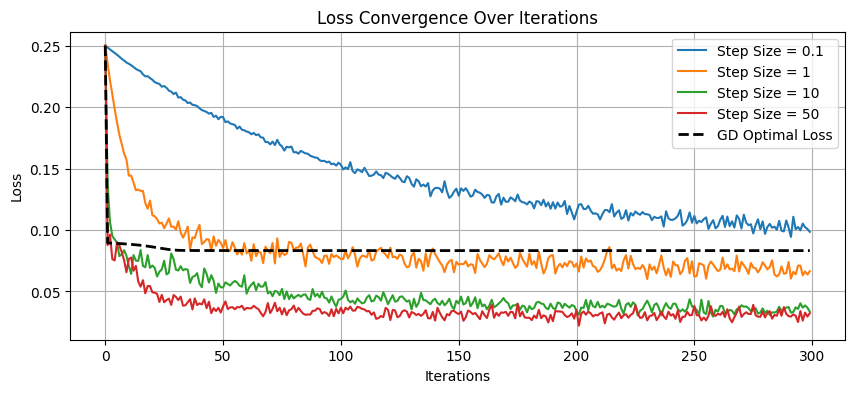

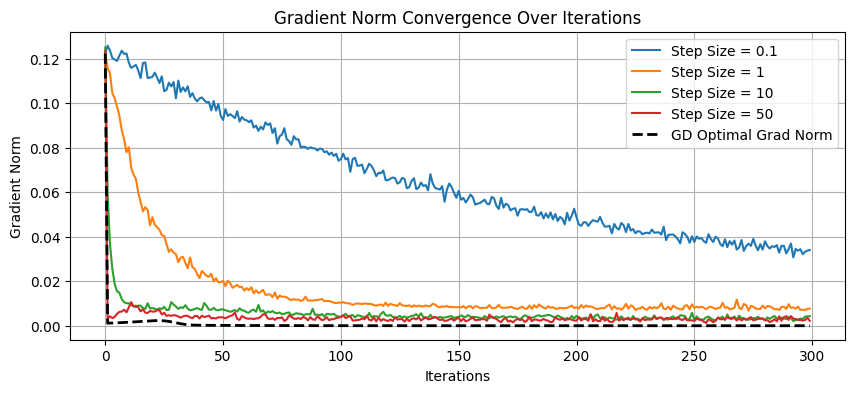

In [22]:
def plot_convergence(all_losses, all_grad_norms, step_sizes, nb_iters):


    # Plot Loss Convergence
    plt.figure(figsize=(10, 4))
    for step_size in step_sizes:
        plt.plot(range(nb_iters), all_losses[step_size], label=f"Step Size = {step_size}")
    plt.plot(range(len(losses_gd_opt)), losses_gd_opt, linestyle="--", color="black", linewidth=2, label="GD Optimal Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss Convergence Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Gradient Norm Convergence
    plt.figure(figsize=(10, 4))
    for step_size in step_sizes:
        plt.plot(range(nb_iters), all_grad_norms[step_size], label=f"Step Size = {step_size}")
    plt.plot(range(len(grad_norms_gd_opt)), grad_norms_gd_opt, linestyle="--", color="black", linewidth=2, label="GD Optimal Grad Norm")
    plt.xlabel("Iterations")
    plt.ylabel("Gradient Norm")
    plt.title("Gradient Norm Convergence Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot convergence results
plot_convergence(all_losses, all_grad_norms, step_sizes, nb_iters)

***Now Study the effect of Batch_size***

In [23]:

batch_sizes = [100, 500, 1000, 2500]

stepsize = 60
nb_iters = 300
x0 = torch.zeros((X_tensor.shape[1], 1))  # Initial parameter vector

# Storage dictionaries
all_losses = {}
all_grad_norms = {}

# Run SGD for each batch size and store results
for batch_size in batch_sizes:
    print(f"\nRunning SGD for batch size: {batch_size}")
    x_sgd_opt, grad_norms, losses = Stochastic_grad_descent(x0, stepsize, X_df, y_df, batch_size, nb_iters)

    all_losses[batch_size] = losses
    all_grad_norms[batch_size] = grad_norms

# Print available batch sizes (debugging)
print(f"\nAvailable batch sizes in all_losses: {list(all_losses.keys())}")



Running SGD for batch size: 100
Iteration 0/300: Loss = 0.250000, Grad Norm = 0.125137
Iteration 10/300: Loss = 0.053963, Grad Norm = 0.005649
Iteration 20/300: Loss = 0.064817, Grad Norm = 0.013166
Iteration 30/300: Loss = 0.052420, Grad Norm = 0.012901
Iteration 40/300: Loss = 0.039747, Grad Norm = 0.012279
Iteration 50/300: Loss = 0.030154, Grad Norm = 0.007620
Iteration 60/300: Loss = 0.044436, Grad Norm = 0.012173
Iteration 70/300: Loss = 0.048865, Grad Norm = 0.009374
Iteration 80/300: Loss = 0.019012, Grad Norm = 0.010106
Iteration 90/300: Loss = 0.036472, Grad Norm = 0.010842
Iteration 100/300: Loss = 0.037459, Grad Norm = 0.012336
Iteration 110/300: Loss = 0.026717, Grad Norm = 0.010293
Iteration 120/300: Loss = 0.048437, Grad Norm = 0.013843
Iteration 130/300: Loss = 0.026535, Grad Norm = 0.007881
Iteration 140/300: Loss = 0.033681, Grad Norm = 0.007616
Iteration 150/300: Loss = 0.041358, Grad Norm = 0.009275
Iteration 160/300: Loss = 0.030783, Grad Norm = 0.010488
Iteration

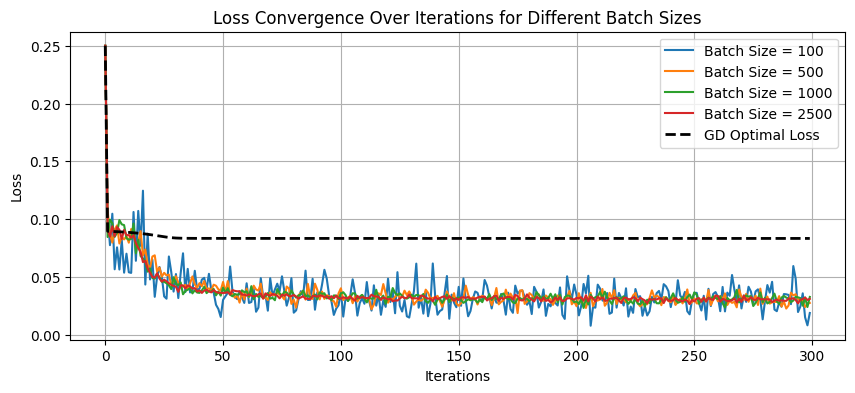

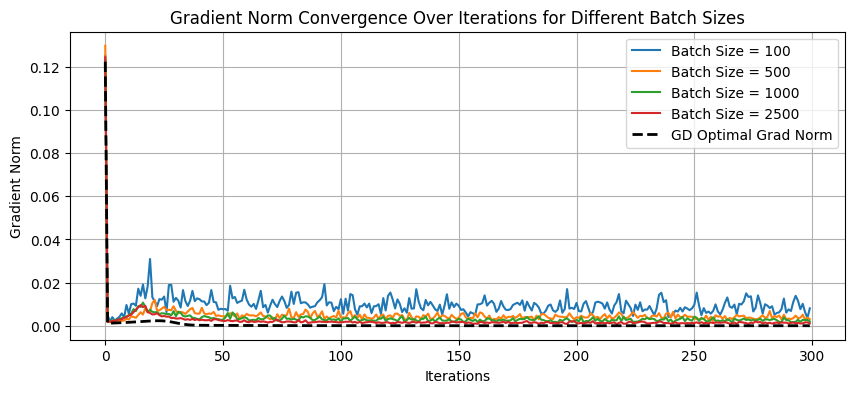

In [24]:
import matplotlib.pyplot as plt

def plot_convergence_batch_sizes(all_losses, all_grad_norms, batch_sizes, nb_iters, losses_gd_opt, grad_norms_gd_opt):


    # Plot Loss Convergence for Different Batch Sizes
    plt.figure(figsize=(10, 4))
    for batch_size in batch_sizes:
        if batch_size in all_losses:
            plt.plot(range(nb_iters), all_losses[batch_size], label=f"Batch Size = {batch_size}")
        else:
            print(f"Warning: Batch size {batch_size} not found in all_losses!")
    plt.plot(range(len(losses_gd_opt)), losses_gd_opt, linestyle="--", color="black", linewidth=2, label="GD Optimal Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss Convergence Over Iterations for Different Batch Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Gradient Norm Convergence for Different Batch Sizes
    plt.figure(figsize=(10, 4))
    for batch_size in batch_sizes:
        if batch_size in all_grad_norms:
            plt.plot(range(nb_iters), all_grad_norms[batch_size], label=f"Batch Size = {batch_size}")
        else:
            print(f"Warning: Batch size {batch_size} not found in all_grad_norms!")
    plt.plot(range(len(grad_norms_gd_opt)), grad_norms_gd_opt, linestyle="--", color="black", linewidth=2, label="GD Optimal Grad Norm")
    plt.xlabel("Iterations")
    plt.ylabel("Gradient Norm")
    plt.title("Gradient Norm Convergence Over Iterations for Different Batch Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot convergence results
plot_convergence_batch_sizes(all_losses, all_grad_norms, batch_sizes, nb_iters, losses_gd_opt, grad_norms_gd_opt)


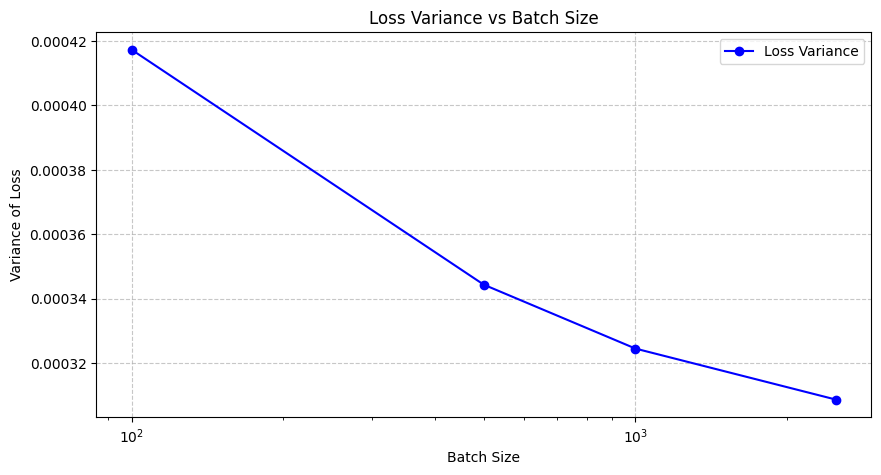

In [25]:
loss_variances = {batch_size: np.var(all_losses[batch_size]) for batch_size in batch_sizes if batch_size in all_losses}

batch_size_list = list(loss_variances.keys())  # Common batch sizes
loss_variance_list = [loss_variances[bs] for bs in batch_size_list]
plt.figure(figsize=(10, 5))
plt.plot(batch_size_list, loss_variance_list, marker='o', linestyle='-', color='blue', label="Loss Variance")
plt.xlabel("Batch Size")
plt.ylabel("Variance of Loss")
plt.title("Loss Variance vs Batch Size")
plt.xscale("log")  # Use log scale if batch sizes vary significantly
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

***CONCLUSIONS and Answers***


*   ***Q: Can you find a good constant stepsize choice for stochastic gradient? What appears to be the best value for the batch size on this problem?***

There is an inherent difficulty in choosing an optimal stepsize in SGD that is not present in Vanilla GD. This is due to the induced randomness of the selection of indices to calculate the gradient. 2 of the 3 theoretical hypotheses for SGD introduced in class  were:

*   $\mathbb{E}(\nabla(f_i)) = \nabla f$

* $\mathbb{E}_i \left[ \|\nabla f_i(x_k)\|^2 \right] \leq \sigma^2 + \|\nabla (x_k)\|^2, \quad \text{with } \sigma^2 \geq 0.$

These are likely not verified in practice. In our instance there is a suffiently large variance on the gradient norm, and the losses and gradient norms are sufficiently close that the "best stepsize" given out by the gridsearch algorithm is random due to the overlap of convergences caused by the choice of batch_size.

Therefore the best methodology is to choose the smallest batchsize - so as to alleviate the computational intensity (allowing you to run more iterations for the same cost) but that is still accurate. For example you can see in the plot above that the batch sizee of 1000, is very close to using a batch size of 2500, but is much less computationally intensive.



* *** Q2: Are your results consistent with the theory***

...Ish!

We expect to see that SGD converge originally faster than GD, but that eventually a well implemented GD will get closer. This is linked to how in the (strong) convex case the SGD convergence result only gives expected convergnce to within an interval of the optimal value whereas GD gives global convergnce

However what we see is that our Gradient Descent algorithm seems to get stuck at a local minima. We see this because the Gradient norm of GD is very close to 0 - meaning it is at a 1st order critical point, however its loss is not 0.

The explanation for the better performance of SGD compared to GD is that SGD "explores" the space better than GD because of the randomness of the gradient. GD will roll like a ball into any local minima wheras SGD has a possibilty of escaping from any local minima by selecting a batch that doesnot follow the gradient. I think this is what is happening here.

There are 2 possible solutions for this:

*   Implement Nesterov/heavy ball as seen in TP2/3
*   Change initialisation point







***Play with different initialisation points***

In [26]:

x0diff = torch.randn((22,1), requires_grad=True)
x_gd_diffinit,grad_norms_gd_diffinit,losses_gd_diffinit = Grad_Descent(x_init = x0diff, stepsize = 60, X_tensor = X_tensor, y_tensor = y_tensor, nb_iters=100)

Iteration 0/100: Loss=0.487265, Grad Norm=0.111088
Iteration 10/100: Loss=0.086388, Grad Norm=0.001207
Iteration 20/100: Loss=0.085547, Grad Norm=0.001166
Iteration 30/100: Loss=0.084760, Grad Norm=0.001111
Iteration 40/100: Loss=0.084117, Grad Norm=0.000914
Iteration 50/100: Loss=0.083753, Grad Norm=0.000625
Iteration 60/100: Loss=0.083589, Grad Norm=0.000423
Iteration 70/100: Loss=0.083507, Grad Norm=0.000324
Iteration 80/100: Loss=0.083454, Grad Norm=0.000273
Iteration 90/100: Loss=0.083414, Grad Norm=0.000238


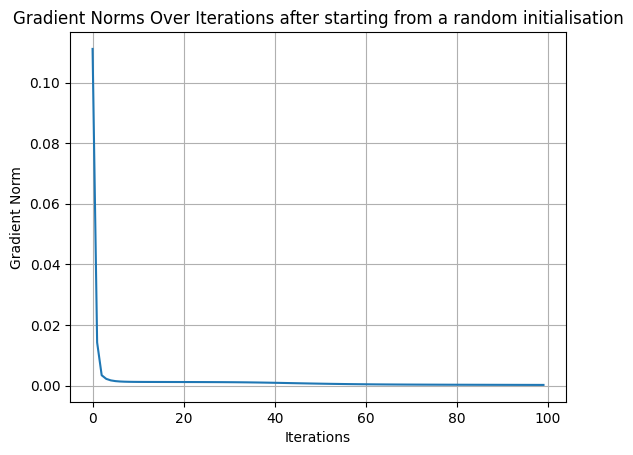

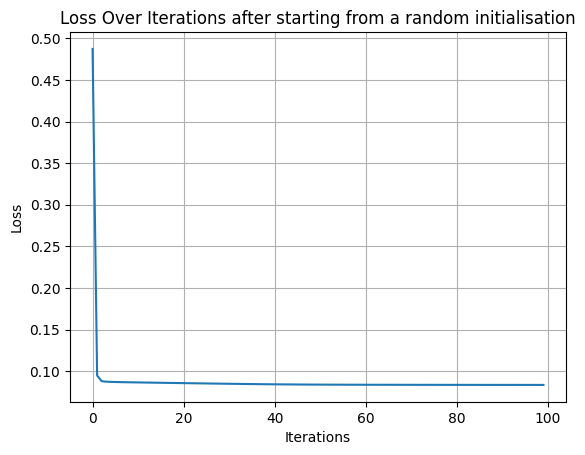

In [27]:
plt.plot(grad_norms_gd_diffinit)
plt.title("Gradient Norms Over Iterations after starting from a random initialisation")
plt.xlabel("Iterations")
plt.ylabel("Gradient Norm")
plt.grid(True)
plt.show()

plt.plot(losses_gd_diffinit)
plt.title("Loss Over Iterations after starting from a random initialisation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

difficult to say exactly but even having changed the initialisation value many times we seem to encounter the same pb.

Another possibility might be to reduce the stepize and let the algorithm run for significantly long - perhaps the largestepsize is the cause, however the code can take a long time to run, so I will have to keep as is.

# Q5 - Adagrad

Taken from TP3:

$$
     [\mathbf{x}_{k+1}]_i  = [\mathbf{x}_k]_i -\frac{\alpha}{\sqrt{[\mathbf{r}_k]_i + \epsilon}}[\nabla f_{i_k}(\mathbf{x}_k)]_i,
 $$
 where $\epsilon>0$ is added to avoid numerical issues, and $\mathbf{r}_k \in \mathbb{R}^d$ is defined recursively by $\mathbf{r}_{-1} = 0_{\mathbb{R}^d}$ and
 $$
     \forall k \ge 0,\ \forall i=1,\dots,d, \qquad
     [\mathbf{r}_k]_i =
     \left\{
         \begin{array}{ll}
             \beta_2 [\mathbf{r}_{k-1}]_i + (1-\beta_2) [\nabla f_{i_k}(\mathbf{x}_k)]_i^2 &\mathrm{for RMSProp,} \\
             [\mathbf{r}_{k-1}]_i + [\nabla f_{i_k}(\mathbf{x}_k)]_i^2 &\mathrm{for Adagrad.}
         \end{array}
     \right.
 $$



In [28]:
import torch

def loss_function_batch(x, A_batch, y_batch):
    z = torch.matmul(A_batch, x)
    sigmoid = 1 / (1 + torch.exp(-z))
    loss = ((y_batch - sigmoid) ** 2).mean()
    return loss

def adagrad_descent(x_init, A, y, nb_iters=300, alpha=0.1, epsilon=1e-8, batch_size=32):

    n, d = A.shape
    x = x_init.detach().clone().requires_grad_(True)  # Ensure proper gradient tracking
    G = torch.zeros_like(x)  # Accumulate squared gradients

    losses = []
    grad_norms = []  # Track gradient norms

    for i in range(nb_iters):
        # 1) Sample a random mini-batch
        indices = torch.randperm(n)[:batch_size]
        A_batch = A[indices]
        y_batch = y[indices]

        # 2) Compute loss on this mini-batch
        loss = loss_function_batch(x, A_batch, y_batch)

        # 3) Compute gradient
        loss.backward()
        grad = x.grad

        losses.append(loss.item())
        grad_norms.append(torch.norm(grad).item())  # Track gradient norm

        # 4) Update accumulator: G += grad^2  (elementwise)
        G += grad * grad

        # 5) Adagrad parameter update
        with torch.no_grad():
            x -= alpha * grad / (torch.sqrt(G) + epsilon)

        # 6) Reset gradient
        x.grad.zero_()

        # Optional: print progress
        if (i+1) % 10 == 0:
            print(f"Iter {i+1}: Loss = {loss.item():.6f}, Grad Norm = {grad_norms[-1]:.6f}")

    return x.detach(), losses, grad_norms  # Now also returns gradient norms


As with the other methods, we will vary the batch/stepsize

In [29]:
x_adagrad_a1b100, loss_adagrada1b100, grad_norms_adagrada1b100 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=1,
        epsilon=1e-8,
        batch_size=100
    )

x_adagrad_a1b500, loss_adagrada1b500, grad_norms_adagrada1b500 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=1,
        epsilon=1e-8,
        batch_size=500
    )

x_adagrad_a1b1000, loss_adagrada1b1000, grad_norms_adagrada1b1000 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=1,
        epsilon=1e-8,
        batch_size=1000
    )

x_adagrad_a1b2500, loss_adagrada1b2500, grad_norms_adagrada1b2500 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=1,
        epsilon=1e-8,
        batch_size=2500
    )


Iter 10: Loss = 0.058387, Grad Norm = 0.004999
Iter 20: Loss = 0.090147, Grad Norm = 0.000726
Iter 30: Loss = 0.081974, Grad Norm = 0.000395
Iter 40: Loss = 0.090259, Grad Norm = 0.001379
Iter 50: Loss = 0.057329, Grad Norm = 0.003024
Iter 60: Loss = 0.081929, Grad Norm = 0.000310
Iter 70: Loss = 0.049235, Grad Norm = 0.004174
Iter 80: Loss = 0.065691, Grad Norm = 0.002458
Iter 90: Loss = 0.073705, Grad Norm = 0.000948
Iter 100: Loss = 0.081995, Grad Norm = 0.000747
Iter 110: Loss = 0.081981, Grad Norm = 0.000601
Iter 120: Loss = 0.081936, Grad Norm = 0.000412
Iter 130: Loss = 0.039750, Grad Norm = 0.003179
Iter 140: Loss = 0.073618, Grad Norm = 0.000150
Iter 150: Loss = 0.116114, Grad Norm = 0.004653
Iter 160: Loss = 0.073707, Grad Norm = 0.000992
Iter 170: Loss = 0.031979, Grad Norm = 0.005034
Iter 180: Loss = 0.131668, Grad Norm = 0.006143
Iter 190: Loss = 0.073791, Grad Norm = 0.001372
Iter 200: Loss = 0.098461, Grad Norm = 0.002226
Iter 210: Loss = 0.081929, Grad Norm = 0.000392
I

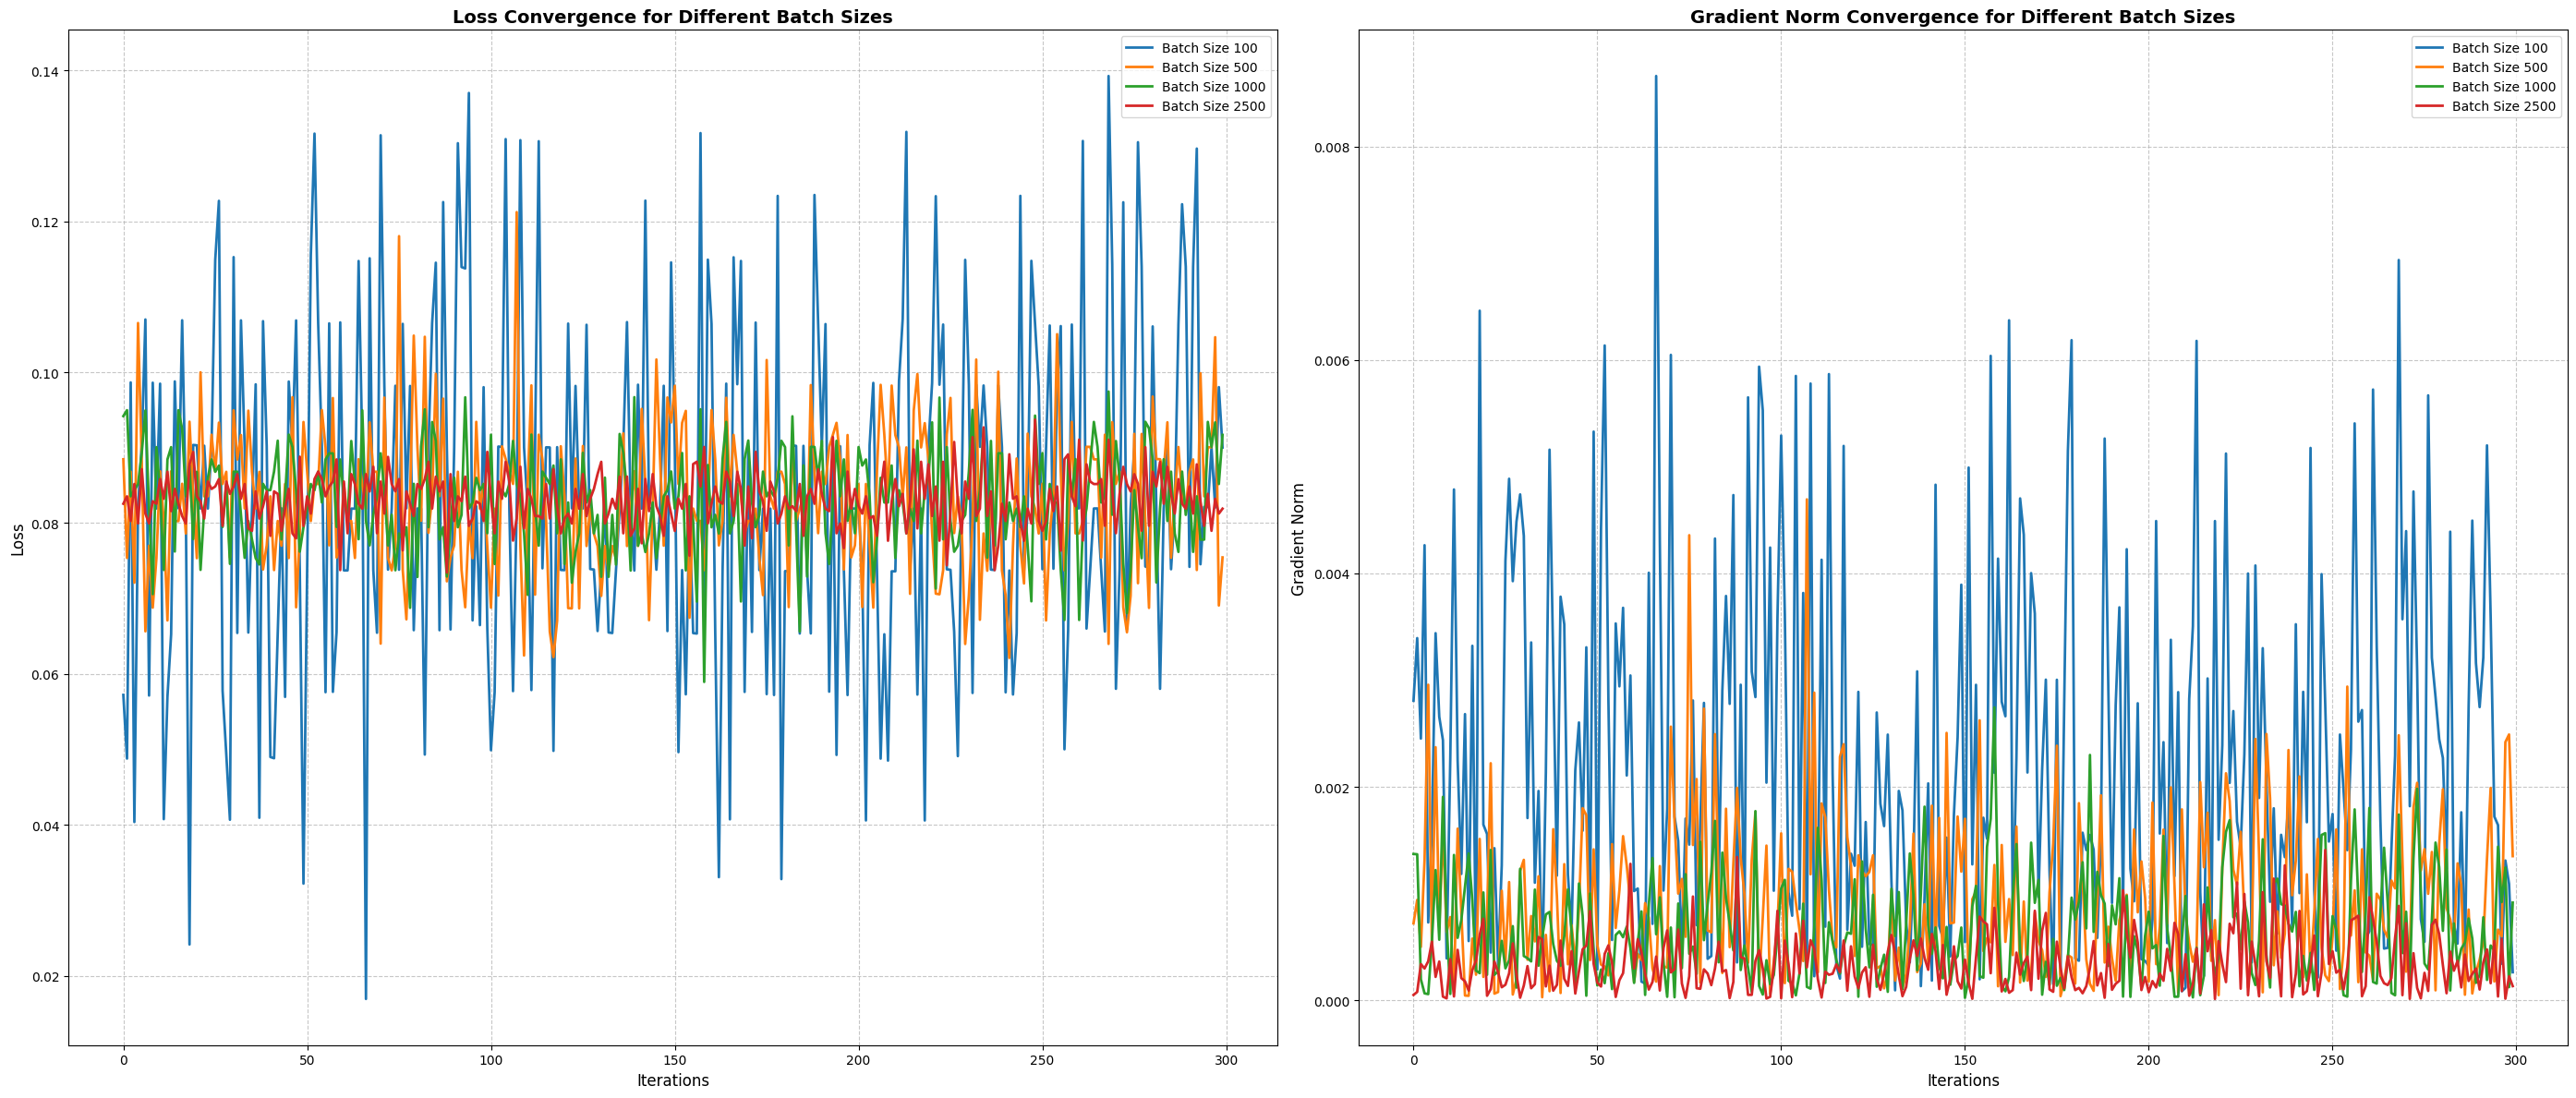

In [30]:
plt.figure(figsize=(28, 12))

# Plot Loss Convergence
plt.subplot(1, 2, 1)
plt.title("Loss Convergence for Different Batch Sizes", fontsize=14, fontweight="bold")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.plot(loss_adagrada1b100[200:500], label="Batch Size 100", linewidth=2)
plt.plot(loss_adagrada1b500[200:500], label="Batch Size 500", linewidth=2)
plt.plot(loss_adagrada1b1000[200:500], label="Batch Size 1000", linewidth=2)
plt.plot(loss_adagrada1b2500[200:500], label="Batch Size 2500", linewidth=2)

plt.legend()


plt.subplot(1, 2, 2)
plt.title("Gradient Norm Convergence for Different Batch Sizes", fontsize=14, fontweight="bold")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Gradient Norm", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.plot(grad_norms_adagrada1b100[200:500], label="Batch Size 100", linewidth=2)
plt.plot(grad_norms_adagrada1b500[200:500], label="Batch Size 500", linewidth=2)
plt.plot(grad_norms_adagrada1b1000[200:500], label="Batch Size 1000", linewidth=2)
plt.plot(grad_norms_adagrada1b2500[200:500], label="Batch Size 2500", linewidth=2)

plt.legend()



plt.tight_layout()
plt.show()

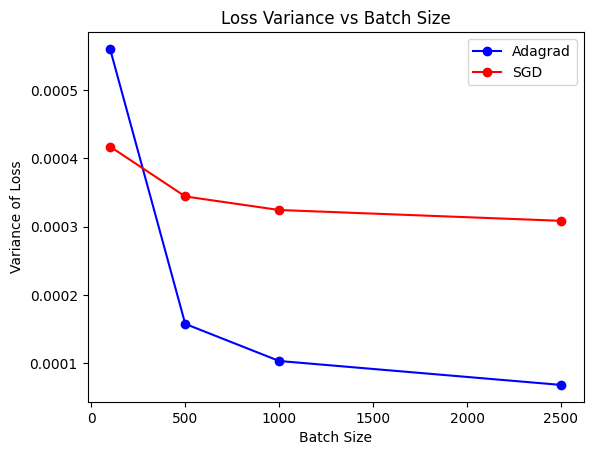

In [31]:
v1 = np.var(loss_adagrada1b100)
v2 = np.var(loss_adagrada1b500)
v3 = np.var(loss_adagrada1b1000)
v4 = np.var(loss_adagrada1b2500)

y = [v1, v2, v3, v4]
x = [100, 500, 1000, 2500]
plt.plot(x, y, marker='o', linestyle='-', color='b', label="Adagrad")
plt.plot(batch_size_list, loss_variance_list, marker='o', linestyle='-', color='r', label="SGD")
plt.xlabel("Batch Size")
plt.ylabel("Variance of Loss")
plt.title("Loss Variance vs Batch Size")
plt.legend()
plt.show()

Interesting graph, adagrad seems to have a lower variance than sgd - they have different step sizes

We can see that we have the same behavior wrt batchsize in adagrad as in SGD

In [32]:
x_adagrad_a1b2500, loss_adagrada1b2500, grad_norms_adagrada1b2500 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=1,
        epsilon=1e-8,
        batch_size=2500
    )

x_adagrad_a5b2500, loss_adagrada5b2500, grad_norms_adagrada5b2500 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=5,
        epsilon=1e-8,
        batch_size=2500
    )

x_adagrad_a10b25000, loss_adagrada10b25000, grad_norms_adagrada10b25000 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=10,
        epsilon=1e-8,
        batch_size=2500
    )

x_adagrad_a20b2500, loss_adagrada20b2500, grad_norms_adagrada20b2500 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=20,
        epsilon=1e-8,
        batch_size=2500
    )

Iter 10: Loss = 0.083219, Grad Norm = 0.001307
Iter 20: Loss = 0.082327, Grad Norm = 0.000549
Iter 30: Loss = 0.084228, Grad Norm = 0.000139
Iter 40: Loss = 0.077041, Grad Norm = 0.000871
Iter 50: Loss = 0.084542, Grad Norm = 0.000294
Iter 60: Loss = 0.075348, Grad Norm = 0.000730
Iter 70: Loss = 0.085521, Grad Norm = 0.000399
Iter 80: Loss = 0.076017, Grad Norm = 0.000757
Iter 90: Loss = 0.081588, Grad Norm = 0.000156
Iter 100: Loss = 0.082570, Grad Norm = 0.000132
Iter 110: Loss = 0.078640, Grad Norm = 0.000486
Iter 120: Loss = 0.077338, Grad Norm = 0.000701
Iter 130: Loss = 0.082240, Grad Norm = 0.000036
Iter 140: Loss = 0.080608, Grad Norm = 0.000326
Iter 150: Loss = 0.085181, Grad Norm = 0.000232
Iter 160: Loss = 0.085180, Grad Norm = 0.000205
Iter 170: Loss = 0.083224, Grad Norm = 0.000148
Iter 180: Loss = 0.080280, Grad Norm = 0.000353
Iter 190: Loss = 0.078973, Grad Norm = 0.000517
Iter 200: Loss = 0.082894, Grad Norm = 0.000014
Iter 210: Loss = 0.090084, Grad Norm = 0.000846
I

In [33]:
x_adagrad_a1b2000, loss_adagrada1b2000, grad_norms_adagrada1b200 = adagrad_descent(
        x0, X_tensor, y_tensor,
        nb_iters=500,
        alpha=1,
        epsilon=1e-8,
        batch_size=2000
    )

Iter 10: Loss = 0.082277, Grad Norm = 0.001260
Iter 20: Loss = 0.082394, Grad Norm = 0.000322
Iter 30: Loss = 0.083171, Grad Norm = 0.000166
Iter 40: Loss = 0.088068, Grad Norm = 0.000658
Iter 50: Loss = 0.087239, Grad Norm = 0.000527
Iter 60: Loss = 0.088871, Grad Norm = 0.000721
Iter 70: Loss = 0.077832, Grad Norm = 0.000635
Iter 80: Loss = 0.079072, Grad Norm = 0.000629
Iter 90: Loss = 0.086403, Grad Norm = 0.000291
Iter 100: Loss = 0.079471, Grad Norm = 0.000512
Iter 110: Loss = 0.082323, Grad Norm = 0.000061
Iter 120: Loss = 0.083960, Grad Norm = 0.000208
Iter 130: Loss = 0.079452, Grad Norm = 0.000292
Iter 140: Loss = 0.078637, Grad Norm = 0.000449
Iter 150: Loss = 0.089673, Grad Norm = 0.000784
Iter 160: Loss = 0.083959, Grad Norm = 0.000155
Iter 170: Loss = 0.084771, Grad Norm = 0.000080
Iter 180: Loss = 0.088857, Grad Norm = 0.000692
Iter 190: Loss = 0.081911, Grad Norm = 0.000041
Iter 200: Loss = 0.077397, Grad Norm = 0.000489
Iter 210: Loss = 0.086014, Grad Norm = 0.000506
I

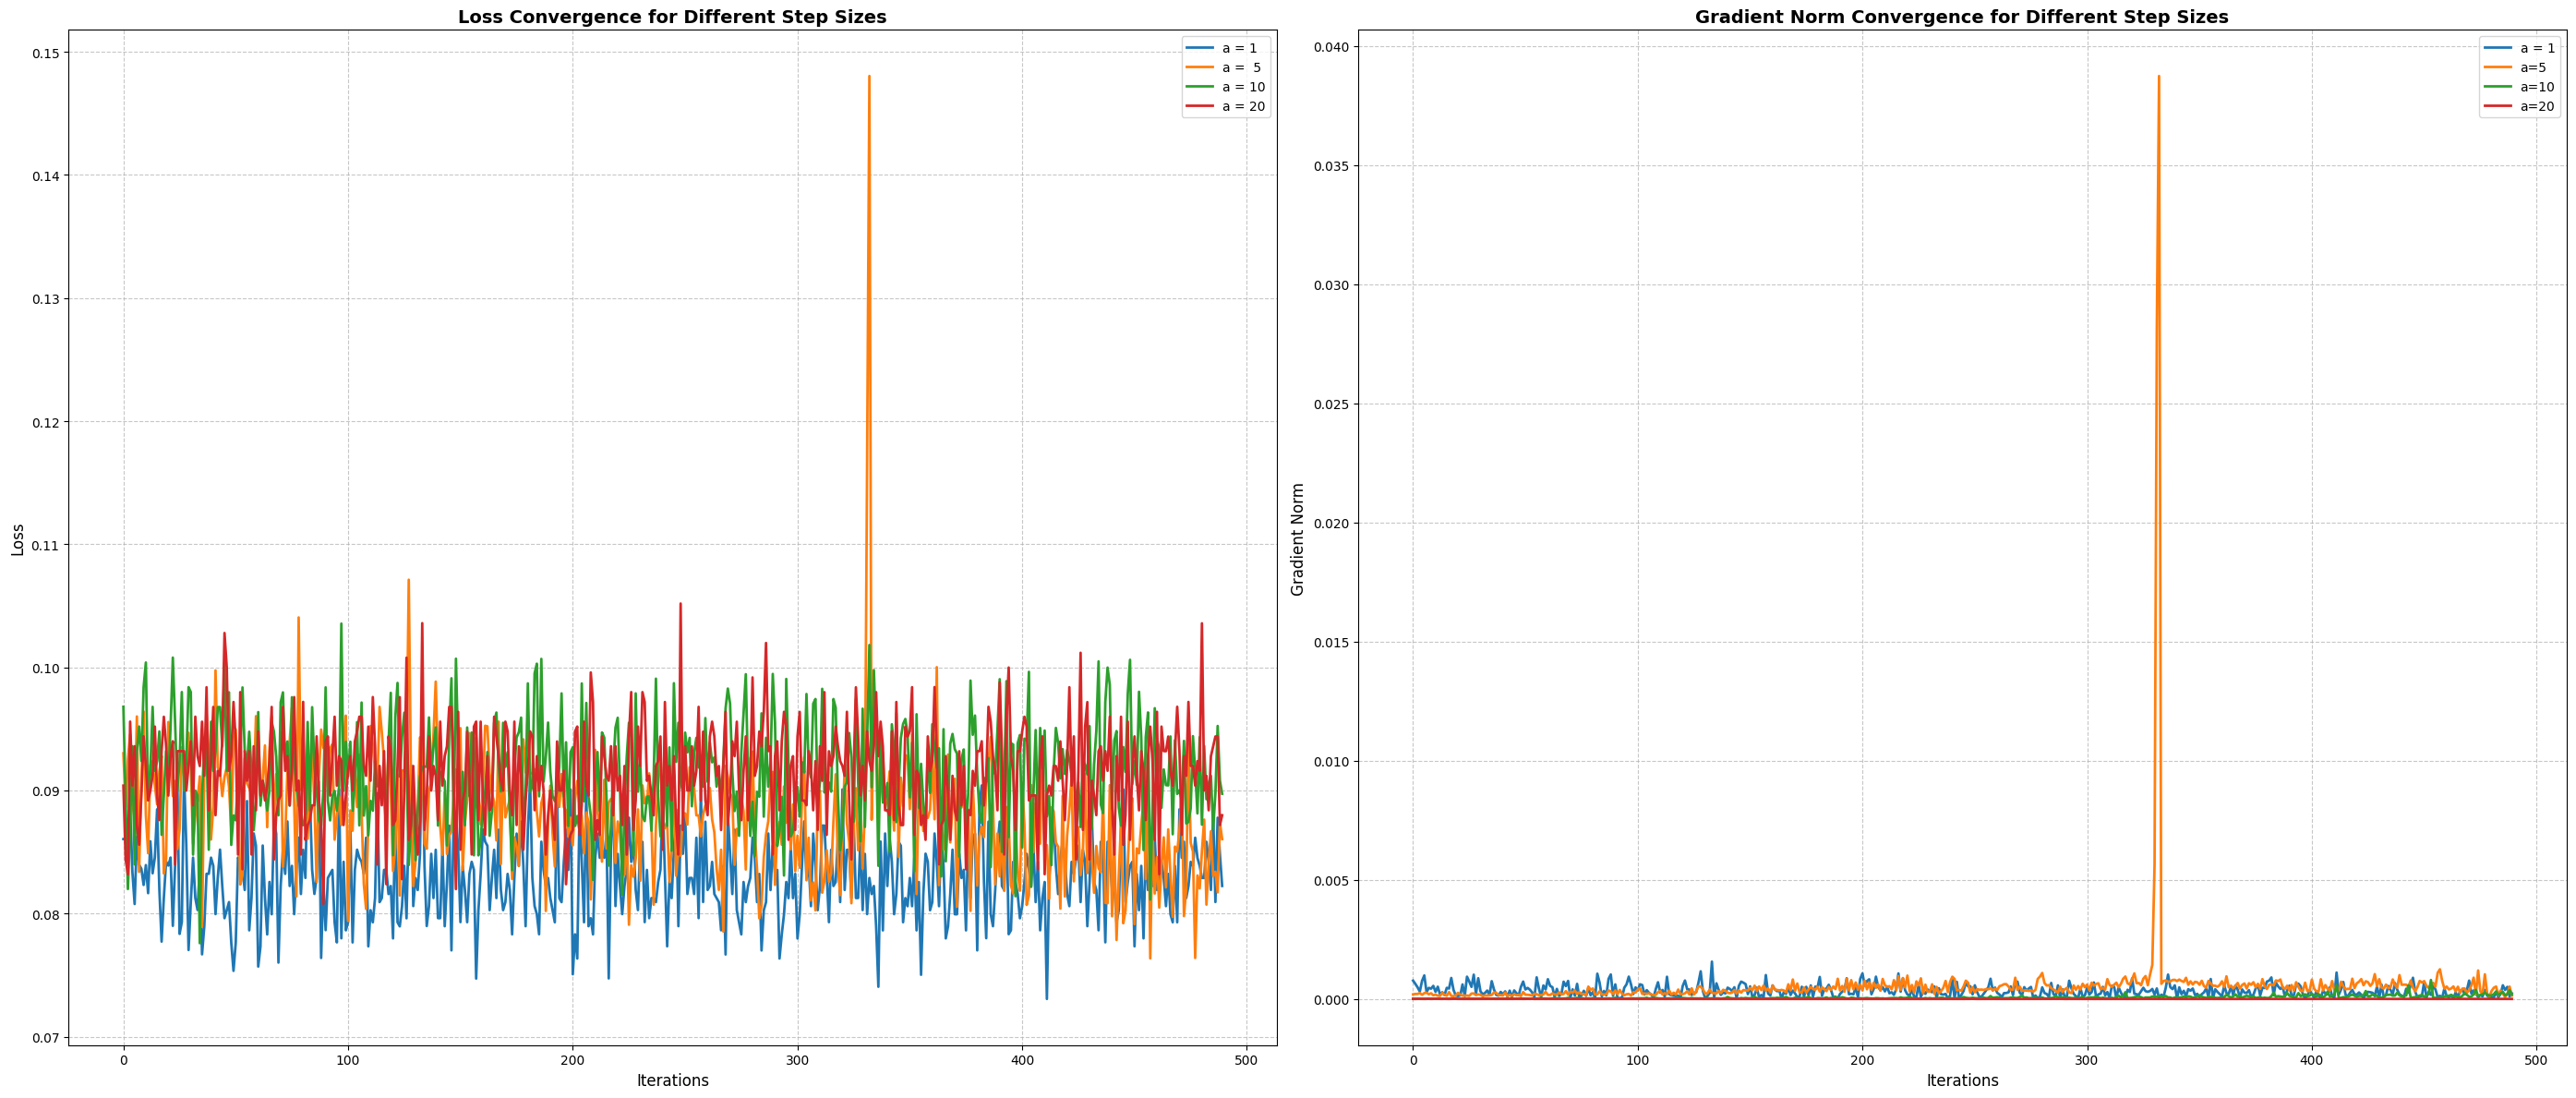

In [34]:
plt.figure(figsize=(28, 12))

# Plot Loss Convergence
plt.subplot(1, 2, 1)
plt.title("Loss Convergence for Different Step Sizes", fontsize=14, fontweight="bold")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.plot(loss_adagrada1b2500[10:], label="a = 1", linewidth=2)
plt.plot(loss_adagrada5b2500[10:], label="a =  5", linewidth=2)
plt.plot(loss_adagrada10b25000[10:], label="a = 10", linewidth=2)
plt.plot(loss_adagrada20b2500[10:], label="a = 20", linewidth=2)

plt.legend()


plt.subplot(1, 2, 2)
plt.title("Gradient Norm Convergence for Different Step Sizes", fontsize=14, fontweight="bold")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Gradient Norm", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.plot(grad_norms_adagrada1b2500[10:500], label="a = 1", linewidth=2)
plt.plot(grad_norms_adagrada5b2500[10:500], label="a=5", linewidth=2)
plt.plot(grad_norms_adagrada10b25000[10:500], label="a=10", linewidth=2)
plt.plot(grad_norms_adagrada20b2500[10:500], label="a=20", linewidth=2)

plt.legend()

plt.tight_layout()
plt.show()

***Compare to best SGD:***

In [35]:
x_sgd_compar, grad_norms_sgd_compar, losses_sgd_compar = Stochastic_grad_descent(x0, 5, X_df, y_df, 1000, 500)

Iteration 0/500: Loss = 0.250000, Grad Norm = 0.122639
Iteration 10/500: Loss = 0.081066, Grad Norm = 0.018406
Iteration 20/500: Loss = 0.077852, Grad Norm = 0.010516
Iteration 30/500: Loss = 0.077355, Grad Norm = 0.008048
Iteration 40/500: Loss = 0.066110, Grad Norm = 0.007240
Iteration 50/500: Loss = 0.068512, Grad Norm = 0.008366
Iteration 60/500: Loss = 0.061110, Grad Norm = 0.007165
Iteration 70/500: Loss = 0.065512, Grad Norm = 0.007533
Iteration 80/500: Loss = 0.063610, Grad Norm = 0.008143
Iteration 90/500: Loss = 0.059713, Grad Norm = 0.006870
Iteration 100/500: Loss = 0.065466, Grad Norm = 0.009109
Iteration 110/500: Loss = 0.057899, Grad Norm = 0.007957
Iteration 120/500: Loss = 0.054037, Grad Norm = 0.005641
Iteration 130/500: Loss = 0.053438, Grad Norm = 0.006459
Iteration 140/500: Loss = 0.046571, Grad Norm = 0.005236
Iteration 150/500: Loss = 0.051785, Grad Norm = 0.005419
Iteration 160/500: Loss = 0.046618, Grad Norm = 0.005633
Iteration 170/500: Loss = 0.045628, Grad N

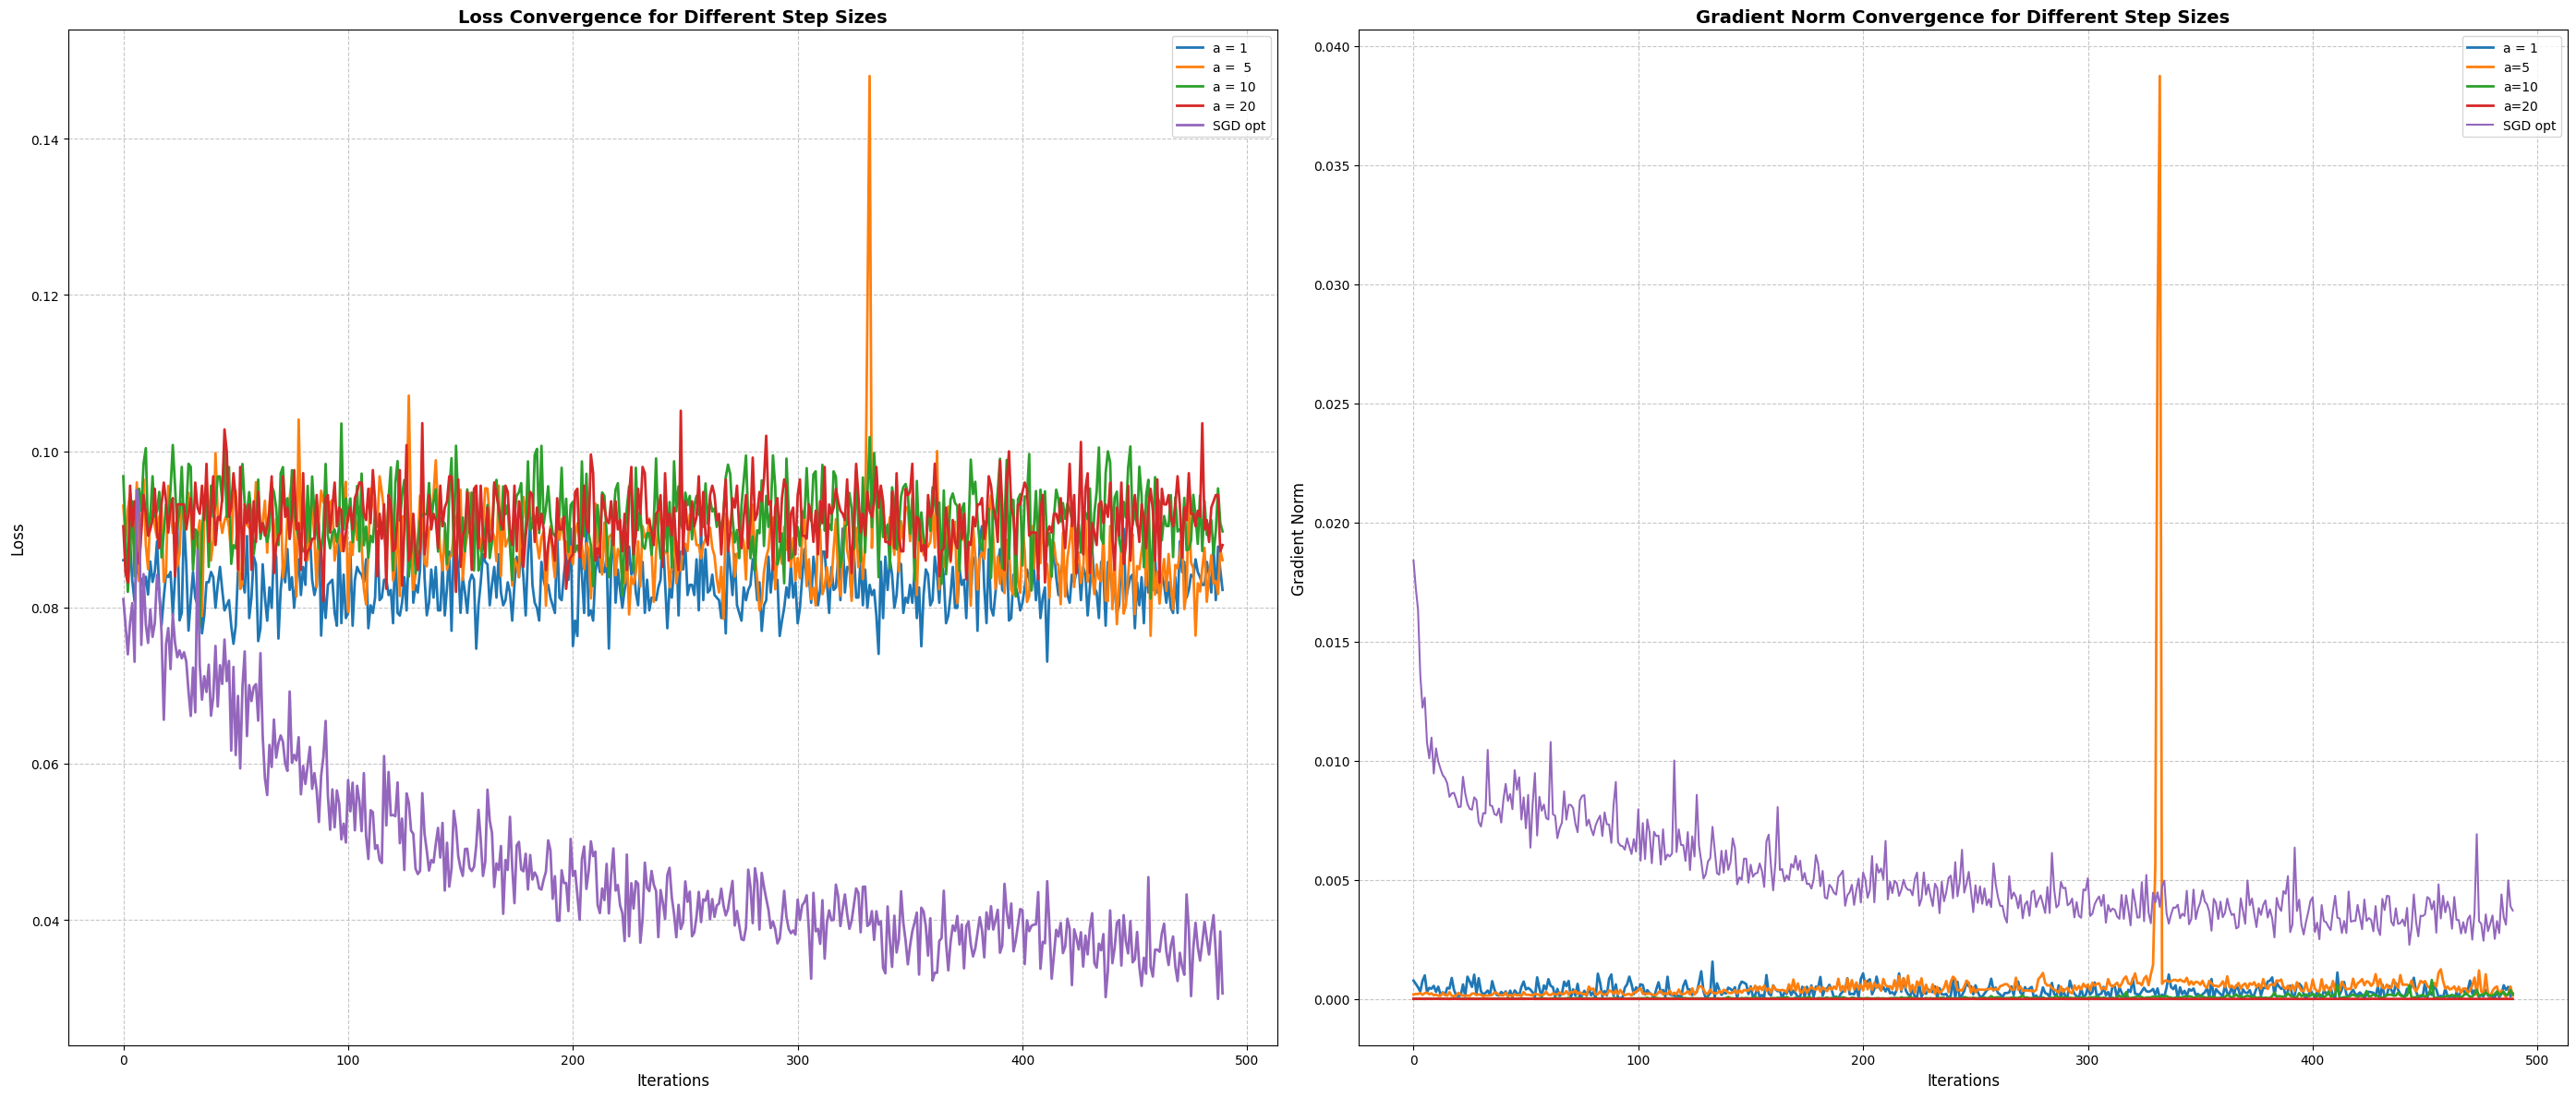

In [36]:
plt.figure(figsize=(28, 12))

# Plot Loss Convergence
plt.subplot(1, 2, 1)
plt.title("Loss Convergence for Different Step Sizes", fontsize=14, fontweight="bold")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.plot(loss_adagrada1b2500[10:], label="a = 1", linewidth=2)
plt.plot(loss_adagrada5b2500[10:], label="a =  5", linewidth=2)
plt.plot(loss_adagrada10b25000[10:], label="a = 10", linewidth=2)
plt.plot(loss_adagrada20b2500[10:], label="a = 20", linewidth=2)
plt.plot(losses_sgd_compar[10:], label="SGD opt", linewidth=2)

plt.legend()


plt.subplot(1, 2, 2)
plt.title("Gradient Norm Convergence for Different Step Sizes", fontsize=14, fontweight="bold")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Gradient Norm", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.plot(grad_norms_adagrada1b2500[10:500], label="a = 1", linewidth=2)
plt.plot(grad_norms_adagrada5b2500[10:500], label="a=5", linewidth=2)
plt.plot(grad_norms_adagrada10b25000[10:500], label="a=10", linewidth=2)
plt.plot(grad_norms_adagrada20b2500[10:500], label="a=20", linewidth=2)
plt.plot(grad_norms_sgd_compar[10:500], label = "SGD opt")
plt.legend()

plt.tight_layout()
plt.show()

This result is surprising. In theory AdaGrad should deal with the sparsity of the dataset the best as it works by adapting the stepsize to the gradient of each element however that is not what is happening. Furthermore the AdaGrad method is getting stuck in the same place that the GD method does which is unusual, however I am unable to find how to fix this

The optimal Adagrad method that I will use for the question 6 is = a = 1, batch = 2500. I chose this because since many hyperparameter combinations give overlapping plots, I chose one with "high" batchsize to decrease variance whilst sppeding up calculations and introducing randomness

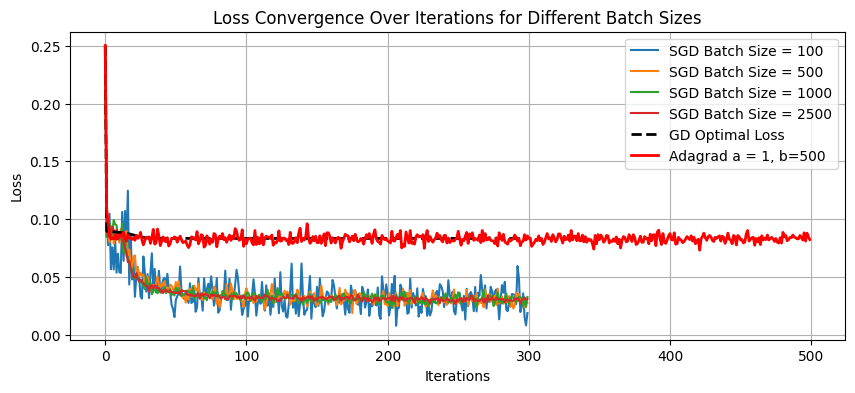

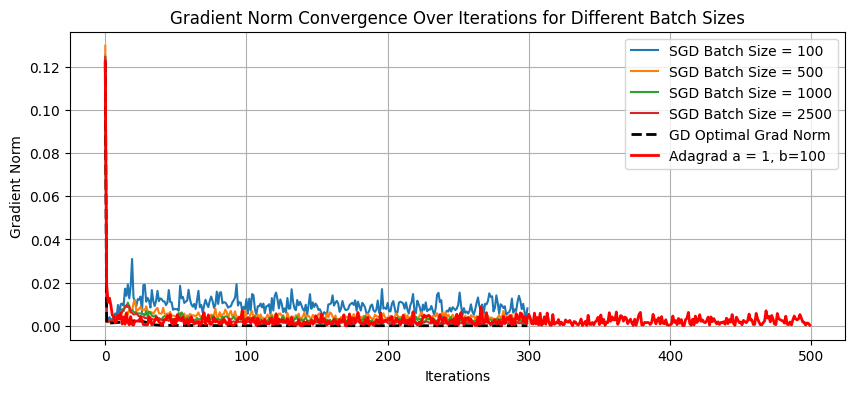

In [37]:
def plot_convergence_batch_sizes(all_losses, all_grad_norms, batch_sizes, nb_iters, losses_gd_opt, grad_norms_gd_opt):


    # Plot Loss Convergence for Different Batch Sizes
    plt.figure(figsize=(10, 4))
    for batch_size in batch_sizes:
        if batch_size in all_losses:
            plt.plot(range(nb_iters), all_losses[batch_size], label=f"SGD Batch Size = {batch_size}")
        else:
            print(f"Warning: Batch size {batch_size} not found in all_losses!")
    plt.plot(range(len(losses_gd_opt)), losses_gd_opt, linestyle="--", color="black", linewidth=2, label="GD Optimal Loss")
    plt.plot(range(len(loss_adagrada1b2500)), loss_adagrada1b2500, color="red", linewidth=2, label="Adagrad a = 1, b=500")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss Convergence Over Iterations for Different Batch Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Gradient Norm Convergence for Different Batch Sizes
    plt.figure(figsize=(10, 4))
    for batch_size in batch_sizes:
        if batch_size in all_grad_norms:
            plt.plot(range(nb_iters), all_grad_norms[batch_size], label=f"SGD Batch Size = {batch_size}")
        else:
            print(f"Warning: Batch size {batch_size} not found in all_grad_norms!")
    plt.plot(range(len(grad_norms_gd_opt)), grad_norms_gd_opt, linestyle="--", color="black", linewidth=2, label="GD Optimal Grad Norm")
    plt.plot(range(len(grad_norms_adagrada1b100)), grad_norms_adagrada1b100, color="red", linewidth=2, label="Adagrad a = 1, b=100")
    plt.xlabel("Iterations")
    plt.ylabel("Gradient Norm")
    plt.title("Gradient Norm Convergence Over Iterations for Different Batch Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot convergence results
plot_convergence_batch_sizes(all_losses, all_grad_norms, batch_sizes, nb_iters, losses_gd_opt, grad_norms_gd_opt)

My only explanation as to the reasoning for this is that the AdaGrad is badly conditioned and needs a larger stepsize - however i get NaN's when i do this because the loss converges too quickly to 0

# ***Q6: Take the Best method from Q5 and apply it to the regularised problem using proximal gradiant method***

Our aim in this question is to

<p>
Minimize:
\[
\min_{x \in \mathbb{R}^d} f(x) + \lambda \|x\|_1
\]
</p>

Since f is smooth and Continuous and the $||x||$ term is a convex regularisation term as per the course we can apply a proximal gradiant method.
We know that the proximal operator for the 1 - norm is the Soft Thresholding operator (ISTA).

The method to integrate ISTA to the Adagrad method is to for each step use AdaGrad to find$x_{k+1}$ and then for each element in this vector we apply ISTA.

The full algorithm is:
**Initialize:**  
- $( G = 0 )$ (accumulated squared gradients)  

**For \( t = 1 \) to \( T ) do:**  
1. Compute gradient:  
   $
   g_t = \nabla f(x_t)
   $
2. Update accumulator:  
   $
   G = G + g_t^2  \quad \text{(element-wise)}
   $
3. Compute Adagrad adaptive step size:  
   $
   \alpha_t = \frac{\alpha}{\sqrt{G} + \epsilon}
   $
4. Perform standard Adagrad update:  
   $
   x_t+1 = x_t - \alpha_t \cdot g_t
   $
5. Apply **proximal operator** (soft-thresholding) to enforce sparsity:  
   $
\text{prox}_{\lambda \|\cdot\|_1}(x_{k+1}^j) =
\begin{cases}
x_{k+1}^j - \lambda, & \text{if } x_{k+1}^j > \lambda \\
0, & \text{if } x_{k+1}^j \in [-\lambda, \lambda] \\
x_{k+1}^j + \lambda, & \text{if } x_{k+1}^j < -\lambda
\end{cases}
$

The code to replicate this is:




In [38]:
def AdaGradISTA(A, y, nb_iters, stepsize, batch_size, epsilon, lbda):
    # Get dataset dimensions
    n, d = A.shape

    # Function to compute loss
    def loss_function_batch(x, A_batch, y_batch):
        z = torch.matmul(A_batch, x)
        sigmoid = 1 / (1 + torch.exp(-z))
        loss = ((y_batch - sigmoid) ** 2).mean()
        return loss

    # Initialize parameters
    x_adagrad = torch.zeros((d, 1), requires_grad=True)
    r = torch.zeros((d, 1))  # Accumulator for Adagrad
    losses_adagrad = []
    grad_norms = []

    for i in range(nb_iters):
        # Sample a mini-batch
        indices = torch.randperm(n)[:batch_size]
        A_batch = A[indices]
        y_batch = y[indices]

        # Compute loss
        loss_adagrad = loss_function_batch(x_adagrad, A_batch, y_batch)
        loss_adagrad.backward()

        with torch.no_grad():
            # Update Adagrad accumulator
            r += x_adagrad.grad ** 2
            scaled_step = stepsize / (torch.sqrt(r) + epsilon)

            # Compute gradient step
            g_k = x_adagrad - scaled_step * x_adagrad.grad

            # Apply Proximal Operator (Soft-Thresholding)
            threshold = lbda * scaled_step
            x_adagrad.copy_(torch.sign(g_k) * torch.max(torch.abs(g_k) - threshold, torch.zeros_like(g_k)))

        # Store loss and gradient norm
        losses_adagrad.append(loss_adagrad.item())
        grad_norms.append(torch.norm(x_adagrad.grad).item())

        # Reset gradients
        x_adagrad.grad.zero_()

        # Print update every 10 iterations
        if i % 10 == 0:
            print(f"λ = {lbda}, Iteration {i}/{nb_iters}: Loss = {loss_adagrad.item():.6f}, Grad Norm = {grad_norms[-1]:.6f}")

    return losses_adagrad, grad_norms, x_adagrad.detach().clone()

Now as the questions asks we take the optimal hyperparameters of the AdaGrad method, and integrate ISTA. We see how these vary wrt lambda

In [39]:
losses_adagradista1, grad_norms_adagradista1, x_adagradista1 = AdaGradISTA(A = X_tensor,
                                                                           y = y_tensor,
                                                                           nb_iters = 500,
                                                                           stepsize = 1,
                                                                           batch_size = 2500,
                                                                           epsilon = 1e-8,
                                                                           lbda = 0.1,)

losses_adagradista2, grad_norms_adagradista2, x_adagradista2 = AdaGradISTA(A = X_tensor,
                                                                           y = y_tensor,
                                                                           nb_iters = 500,
                                                                           stepsize = 1,
                                                                           batch_size = 2500,
                                                                           epsilon = 1e-8,
                                                                           lbda = 0.05)
losses_adagradista3, grad_norms_adagradista3, x_adagradista3 = AdaGradISTA(A = X_tensor,
                                                                           y = y_tensor,
                                                                           nb_iters = 500,
                                                                           stepsize = 1,
                                                                           batch_size = 2500,
                                                                           epsilon = 1e-8,
                                                                           lbda = 0.01)
losses_adagradista4, grad_norms_adagradista4, x_adagradista4 = AdaGradISTA(A = X_tensor,
                                                                           y = y_tensor,
                                                                           nb_iters = 500,
                                                                           stepsize = 1,
                                                                           batch_size = 2500,
                                                                           epsilon = 1e-8,
                                                                           lbda = 0.009)
losses_adagradista5, grad_norms_adagradista5, x_adagradista5 = AdaGradISTA(A = X_tensor,
                                                                           y = y_tensor,
                                                                           nb_iters = 500,
                                                                           stepsize = 1,
                                                                           batch_size = 2500,
                                                                           epsilon = 1e-8,
                                                                           lbda = 0.005)


λ = 0.1, Iteration 0/500: Loss = 0.250000, Grad Norm = 0.121768
λ = 0.1, Iteration 10/500: Loss = 0.239849, Grad Norm = 0.119497
λ = 0.1, Iteration 20/500: Loss = 0.238624, Grad Norm = 0.119414
λ = 0.1, Iteration 30/500: Loss = 0.238528, Grad Norm = 0.116536
λ = 0.1, Iteration 40/500: Loss = 0.239406, Grad Norm = 0.117628
λ = 0.1, Iteration 50/500: Loss = 0.239609, Grad Norm = 0.116755
λ = 0.1, Iteration 60/500: Loss = 0.239004, Grad Norm = 0.118701
λ = 0.1, Iteration 70/500: Loss = 0.238962, Grad Norm = 0.117241
λ = 0.1, Iteration 80/500: Loss = 0.238602, Grad Norm = 0.117073
λ = 0.1, Iteration 90/500: Loss = 0.238304, Grad Norm = 0.117819
λ = 0.1, Iteration 100/500: Loss = 0.238479, Grad Norm = 0.119217
λ = 0.1, Iteration 110/500: Loss = 0.238653, Grad Norm = 0.117916
λ = 0.1, Iteration 120/500: Loss = 0.238588, Grad Norm = 0.117854
λ = 0.1, Iteration 130/500: Loss = 0.238638, Grad Norm = 0.118788
λ = 0.1, Iteration 140/500: Loss = 0.238949, Grad Norm = 0.117656
λ = 0.1, Iteration 15

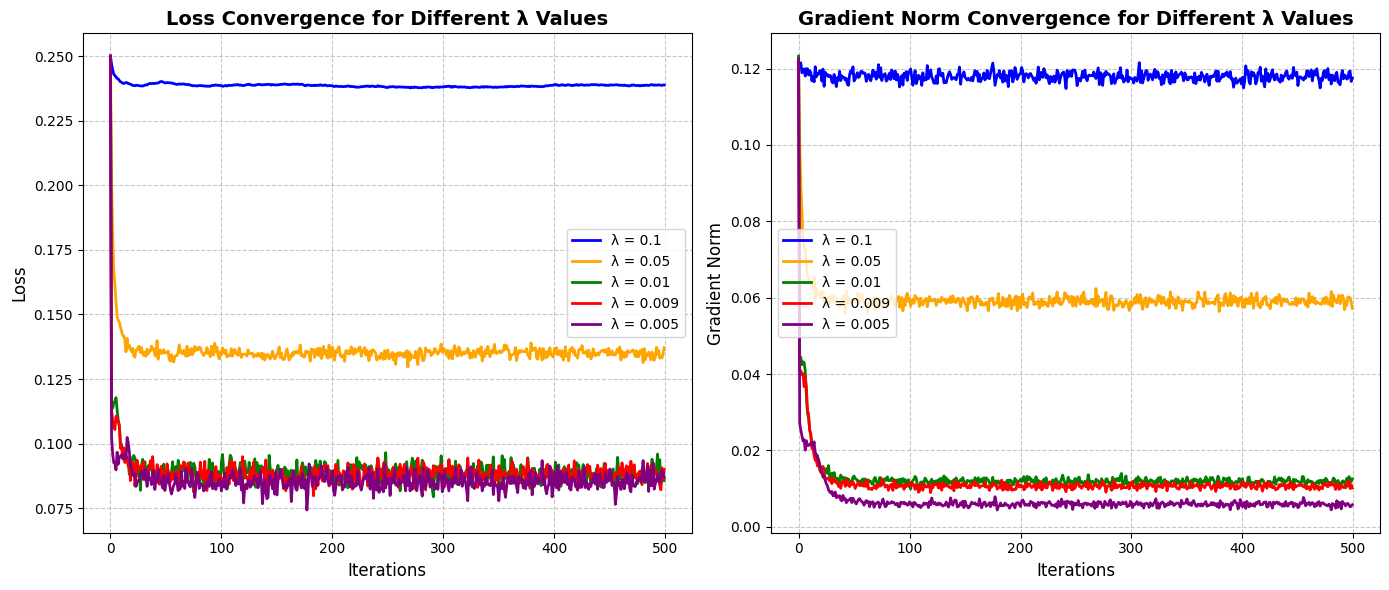

In [40]:
plt.figure(figsize=(14, 6))

# Define colors for different lambda values
colors = ["blue", "orange", "green", "red", "purple"]

# Plot Loss Convergence for Different Lambda Values
plt.subplot(1, 2, 1)
plt.plot(losses_adagradista1, label="λ = 0.1", linewidth=2, color=colors[0])
plt.plot(losses_adagradista2, label="λ = 0.05", linewidth=2, color=colors[1])
plt.plot(losses_adagradista3, label="λ = 0.01", linewidth=2, color=colors[2])
plt.plot(losses_adagradista4, label="λ = 0.009", linewidth=2, color=colors[3])
plt.plot(losses_adagradista5, label="λ = 0.005", linewidth=2, color=colors[4])
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Convergence for Different λ Values", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Plot Gradient Norm Convergence for Different Lambda Values
plt.subplot(1, 2, 2)
plt.plot(grad_norms_adagradista1, label="λ = 0.1", linewidth=2, color=colors[0])
plt.plot(grad_norms_adagradista2, label="λ = 0.05", linewidth=2, color=colors[1])
plt.plot(grad_norms_adagradista3, label="λ = 0.01", linewidth=2, color=colors[2])
plt.plot(grad_norms_adagradista4, label="λ = 0.009", linewidth=2, color=colors[3])
plt.plot(grad_norms_adagradista5, label="λ = 0.005", linewidth=2, color=colors[4])
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Gradient Norm", fontsize=12)
plt.title("Gradient Norm Convergence for Different λ Values", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Display plots
plt.tight_layout()
plt.show()

Now we investigate the sparsity of the solutions.



In [41]:
nonzero_counts = [
    (x_adagradista1.abs() > 1e-6).sum().item(),
    (x_adagradista2.abs() > 1e-6).sum().item(),
    (x_adagradista3.abs() > 1e-6).sum().item(),
    (x_adagradista4.abs() > 1e-6).sum().item(),
    (x_adagradista5.abs() > 1e-6).sum().item(),
]

We implement the hyperparameters for our best version of Adagrad from the question before a = 1, nb = 2500, and we investigate the convergence as the reg parameter varies.

Lambda = 0, Iteration 0/300: Adagrad Loss = 0.25
Lambda = 0, Iteration 10/300: Adagrad Loss = 0.08664146065711975
Lambda = 0, Iteration 20/300: Adagrad Loss = 0.08456654101610184
Lambda = 0, Iteration 30/300: Adagrad Loss = 0.07737042009830475
Lambda = 0, Iteration 40/300: Adagrad Loss = 0.07963106781244278
Lambda = 0, Iteration 50/300: Adagrad Loss = 0.07799816876649857
Lambda = 0, Iteration 60/300: Adagrad Loss = 0.07896605134010315
Lambda = 0, Iteration 70/300: Adagrad Loss = 0.08158812671899796
Lambda = 0, Iteration 80/300: Adagrad Loss = 0.0796222984790802
Lambda = 0, Iteration 90/300: Adagrad Loss = 0.0920879989862442
Lambda = 0, Iteration 100/300: Adagrad Loss = 0.07930345833301544
Lambda = 0, Iteration 110/300: Adagrad Loss = 0.08126155287027359
Lambda = 0, Iteration 120/300: Adagrad Loss = 0.0819140374660492
Lambda = 0, Iteration 130/300: Adagrad Loss = 0.08780328929424286
Lambda = 0, Iteration 140/300: Adagrad Loss = 0.08060377091169357
Lambda = 0, Iteration 150/300: Adagrad 

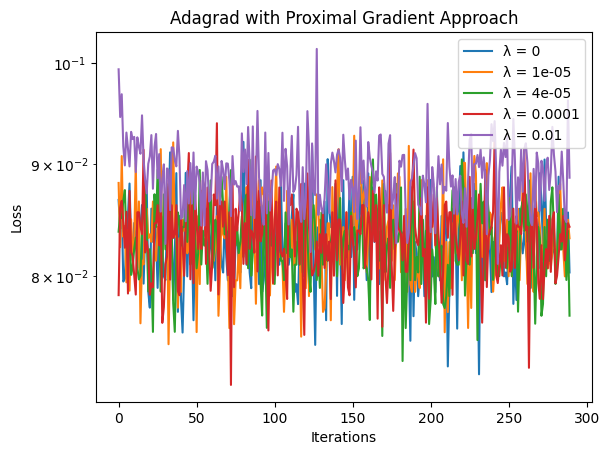

λ = 0: Number of Nonzero Coefficients = 22
λ = 1e-05: Number of Nonzero Coefficients = 12
λ = 4e-05: Number of Nonzero Coefficients = 12
λ = 0.0001: Number of Nonzero Coefficients = 12
λ = 0.01: Number of Nonzero Coefficients = 1


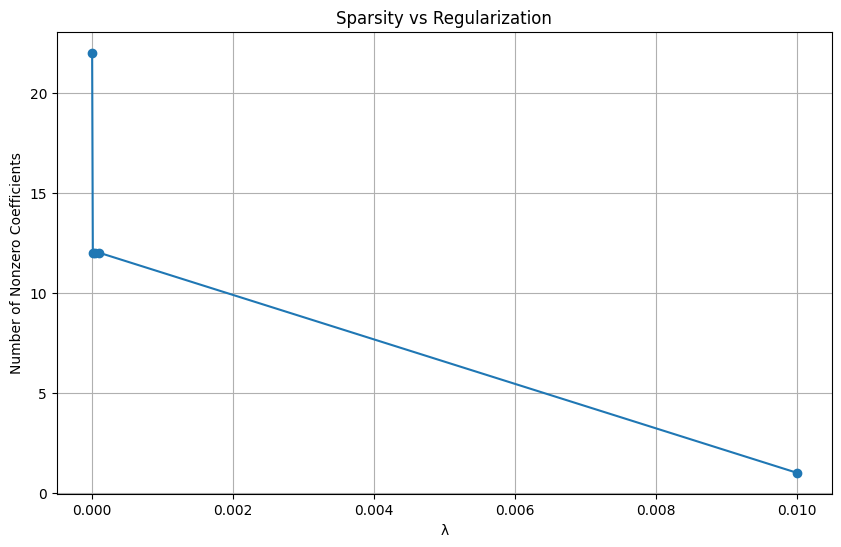

In [42]:
A = torch.tensor(X_df.values, dtype=torch.float32)
y = torch.tensor(y_df.values, dtype=torch.float32).unsqueeze(1)


n, d = A.shape
nb_iters = 300
stepsize = 1
batch_size = n // 2
epsilon = 1e-8
lambda_vals = [0, 0.00001,0.00004,0.0001,0.01]
# Fonction de perte pour un batch
def loss_function_batch(x, A_batch, y_batch):
    z = torch.matmul(A_batch, x)
    sigmoid = 1 / (1 + torch.exp(-z))
    loss = ((y_batch - sigmoid) ** 2).mean()
    return loss

# Stockage des résultats pour la parcimonie
nonzero_counts = []

# ISTA combinée avec Adagrad
for lbda in lambda_vals:
    x_adagrad = torch.zeros((d, 1), requires_grad=True)
    r = torch.zeros((d, 1))  # Accumulateur pour Adagrad
    losses_adagrad = []

    for i in range(nb_iters):
        # Tirage aléatoire d'un batch
        indices = torch.randperm(n)[:batch_size]
        A_batch = A[indices]
        y_batch = y[indices]

        # Calcul de la perte sur le batch
        loss_adagrad = loss_function_batch(x_adagrad, A_batch, y_batch)
        loss_adagrad.backward()

        with torch.no_grad():
            # Mise à jour Adagrad
            r += x_adagrad.grad ** 2
            scaled_step = stepsize / (torch.sqrt(r) + epsilon)
            g_k = x_adagrad - scaled_step * x_adagrad.grad  # Gradient step

            # Proximal update (soft-thresholding)
            threshold = lbda * scaled_step
            x_adagrad.copy_(torch.sign(g_k) * torch.max(torch.abs(g_k) - threshold, torch.zeros_like(g_k)))

        # Stockage de la perte
        losses_adagrad.append(loss_adagrad.item())
        x_adagrad.grad.zero_()  # Réinitialiser les gradients

        # Affichage périodique
        if i % 10 == 0:
            print(f"Lambda = {lbda}, Iteration {i}/{nb_iters}: Adagrad Loss = {loss_adagrad.item()}")

    # Calcul du nombre de coefficients non nuls pour ce lambda
   # print(x_adagrad)
    with torch.no_grad():
        nonzero_counts.append((x_adagrad.abs() > 1e-7).sum().item())

    # Visualisation des pertes
    plt.semilogy(losses_adagrad[10:], label=f"λ = {lbda}")

# Plot des pertes
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Adagrad with Proximal Gradient Approach")
plt.legend()
plt.show()

for lbda, nonzero_count in zip(lambda_vals, nonzero_counts):
    print(f"λ = {lbda}: Number of Nonzero Coefficients = {nonzero_count}")


# Visualisation de la parcimonie (sparsity) en fonction de λ
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, nonzero_counts, marker='o')
plt.xlabel("λ")
plt.ylabel("Number of Nonzero Coefficients")
plt.title("Sparsity vs Regularization")
plt.grid()
plt.show()

Lambda = 0, Iteration 0/200: Adagrad Loss = 0.25
Lambda = 0, Iteration 10/200: Adagrad Loss = 0.14316843450069427
Lambda = 0, Iteration 20/200: Adagrad Loss = 0.11827246099710464
Lambda = 0, Iteration 30/200: Adagrad Loss = 0.10834836214780807
Lambda = 0, Iteration 40/200: Adagrad Loss = 0.10465007275342941
Lambda = 0, Iteration 50/200: Adagrad Loss = 0.10178908705711365
Lambda = 0, Iteration 60/200: Adagrad Loss = 0.09428197890520096
Lambda = 0, Iteration 70/200: Adagrad Loss = 0.09519311040639877
Lambda = 0, Iteration 80/200: Adagrad Loss = 0.09083966165781021
Lambda = 0, Iteration 90/200: Adagrad Loss = 0.09182287752628326
Lambda = 0, Iteration 100/200: Adagrad Loss = 0.0890241414308548
Lambda = 0, Iteration 110/200: Adagrad Loss = 0.08942241221666336
Lambda = 0, Iteration 120/200: Adagrad Loss = 0.08466184139251709
Lambda = 0, Iteration 130/200: Adagrad Loss = 0.09287799894809723
Lambda = 0, Iteration 140/200: Adagrad Loss = 0.08799056708812714
Lambda = 0, Iteration 150/200: Adagra

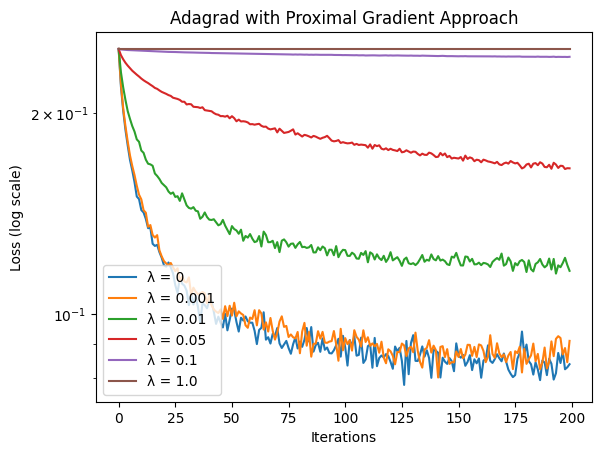

λ = 0: Number of Nonzero Coefficients = 22
λ = 0.001: Number of Nonzero Coefficients = 11
λ = 0.01: Number of Nonzero Coefficients = 11
λ = 0.05: Number of Nonzero Coefficients = 1
λ = 0.1: Number of Nonzero Coefficients = 1
λ = 1.0: Number of Nonzero Coefficients = 0


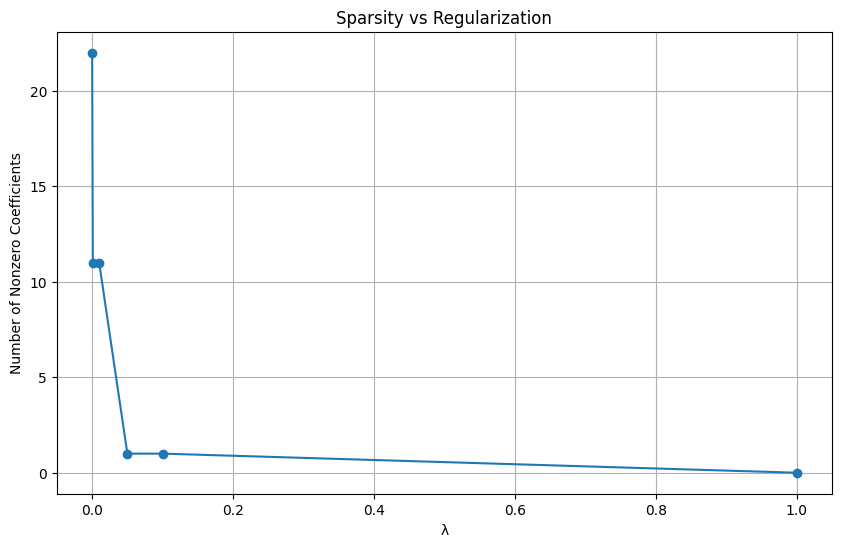

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Conversion des données en tenseurs
A = torch.tensor(X_df.values, dtype=torch.float32)
y = torch.tensor(y_df.values, dtype=torch.float32).unsqueeze(1)

# Initialisation des paramètres
n, d = A.shape  # Taille de A
nb_iters = 200  # Nombre d'itérations
stepsize = 0.1  # Pas d'apprentissage initial
batch_size = n // 2  # Taille du batch
epsilon = 1e-8  # Petit terme pour éviter la division par zéro
lambda_vals = [0, 0.001, 0.01, 0.05, 0.1, 1.0]  # Valeurs de régularisation

# Fonction de perte pour un batch
def loss_function_batch(x, A_batch, y_batch):
    z = torch.matmul(A_batch, x)
    sigmoid = 1 / (1 + torch.exp(-z))
    loss = ((y_batch - sigmoid) ** 2).mean()
    return loss

# Stockage des résultats pour la parcimonie
nonzero_counts = []

# ISTA combinee avec Adagrad
for lbda in lambda_vals:
    x_adagrad = torch.zeros((d, 1), requires_grad=True)
    r = torch.zeros((d, 1))  # Accumulateur pour Adagrad
    losses_adagrad = []

    for i in range(nb_iters):
        # Tirage aléatoire d'un batch
        indices = torch.randperm(n)[:batch_size]
        A_batch = A[indices]
        y_batch = y[indices]

        # Calcul de la perte sur le batch
        loss_adagrad = loss_function_batch(x_adagrad, A_batch, y_batch)
        loss_adagrad.backward()

        with torch.no_grad():
            # Mise à jour Adagrad
            r += x_adagrad.grad ** 2
            scaled_step = stepsize / (torch.sqrt(r) + epsilon)
            g_k = x_adagrad - scaled_step * x_adagrad.grad  # Gradient step

            # Proximal update (soft-thresholding)
            threshold = lbda * scaled_step
            x_adagrad.copy_(torch.sign(g_k) * torch.max(torch.abs(g_k) - threshold, torch.zeros_like(g_k)))

        # Stockage de la perte
        losses_adagrad.append(loss_adagrad.item())
        x_adagrad.grad.zero_()  # Réinitialiser les gradients

        # Affichage périodique
        if i % 10 == 0:
            print(f"Lambda = {lbda}, Iteration {i}/{nb_iters}: Adagrad Loss = {loss_adagrad.item()}")

    # Calcul du nombre de coefficients non nuls pour ce lambda
    with torch.no_grad():
        nonzero_counts.append((x_adagrad.abs() > 1e-6).sum().item())

    # Visualisation des pertes
    plt.semilogy(losses_adagrad, label=f"λ = {lbda}")

# Plot des pertes
plt.xlabel("Iterations")
plt.ylabel("Loss (log scale)")
plt.title("Adagrad with Proximal Gradient Approach")
plt.legend()
plt.show()

for lbda, nonzero_count in zip(lambda_vals, nonzero_counts):
    print(f"λ = {lbda}: Number of Nonzero Coefficients = {nonzero_count}")


# sparsity en fonction de λ
plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, nonzero_counts, marker='o')
plt.xlabel("λ")
plt.ylabel("Number of Nonzero Coefficients")
plt.title("Sparsity vs Regularization")
plt.grid()
plt.show()

there are many lambda values that make the vector  sparse and give loww loss

# ***Section B Quasi Newton Techniques***

# ***Q7: BFGS***


This method wasn't studied on the course, it is  a second order method that uses an approximation of the Hessian.

In [44]:
def f(x, A, y):
    z = A @ x
    sigmoid = 1 / (1 + torch.exp(-z))
    loss_per_sample = (y - sigmoid)**2
    return loss_per_sample.mean()


In [45]:
import torch

def bfgs_minimize(f, A, y, alpha, max_iters, tol=1e-4):
    """
    Performs BFGS to minimize f(x, A, y) given:
      x_{k+1} = x_k - alpha * H_k * grad f(x_k)
      H_{k+1} updated via BFGS if s_k^T v_k > 0.

    If the algorithm stops early, it returns the best point found
    and fills the rest of the iterations with this point.

    Args:
        f:         function f(x, A, y) -> scalar
        A:         shape (n, d)
        y:         shape (n,)
        alpha:     step size (constant)
        max_iters: number of iterations
        tol:       gradient norm tolerance for early stopping

    Returns:
        x:            the final parameter vector
        losses:       list of loss values over iterations (filled with best loss if stopped early)
        grad_norms:   list of gradient norm values over iterations (filled if stopped early)
    """
    # Dimensions
    n, d = A.shape

    # Initialize x and H
    x = torch.zeros(d, dtype=torch.float32)  # No requires_grad since we handle grads manually.
    H = torch.eye(d, dtype=torch.float32)    # BFGS needs a (d x d) matrix for H_k

    losses = []
    grad_norms = []  # Store gradient norms

    # Track the best x and lowest loss encountered
    best_x = x.clone()
    best_loss = float("inf")
    best_grad_norm = float("inf")

    # Helper to get gradient using PyTorch autograd
    def get_grad(x):
        x_temp = x.detach().clone().requires_grad_(True)
        loss_value = f(x_temp, A, y)
        loss_value.backward()
        return x_temp.grad, loss_value.item()

    # Main loop
    for k in range(max_iters):
        # Compute gradient and current loss
        grad_k, loss_k = get_grad(x)
        losses.append(loss_k)
        grad_norms.append(grad_k.norm().item())

        # Track the best x found
        if loss_k < best_loss:
            best_loss = loss_k
            best_x = x.clone()
            best_grad_norm = grad_norms[-1]

        # Check for early stopping
        if grad_norms[-1] < tol:
            print(f"Terminating at iteration {k} due to small gradient norm: {grad_norms[-1]:.2e}")
            break

        # Take step: x_{k+1} = x_k - alpha * H_k * grad_k
        x_new = x - alpha * (H @ grad_k)

        # Compute s_k = x_{k+1} - x_k
        s_k = x_new - x

        # Compute new gradient grad_{k+1}
        grad_kplus1, loss_kplus1 = get_grad(x_new)

        # Compute v_k = grad_{k+1} - grad_k
        v_k = grad_kplus1 - grad_k

        # BFGS update if s_k^T v_k > 0
        s_dot_v = torch.dot(s_k, v_k)
        if s_dot_v > 1e-12:  # Small threshold to avoid numerical issues
            s_k_column = s_k.view(-1, 1)  # shape (d,1)
            s_k_row    = s_k.view(1, -1)  # shape (1,d)
            v_k_column = v_k.view(-1, 1)
            v_k_row    = v_k.view(1, -1)

            I = torch.eye(d)
            term1 = I - (v_k_column @ s_k_row) / s_dot_v
            term2 = I - (s_k_column @ v_k_row) / s_dot_v

            H = term1 @ H @ term2 + (s_k_column @ s_k_row) / s_dot_v
        else:
            print(f"Skipping BFGS update at iteration {k}; s^T v = {s_dot_v.item():.2e}")

        # Update x
        x = x_new

        if (k+1) % 10 == 0:
            print(f"Iter: {k+1}, Loss: {loss_kplus1:.6f}, GradNorm: {grad_norms[-1]:.3e}")

    # If optimization stopped early, fill the remaining iterations with the best found values
    remaining_iters = max_iters - len(losses)
    if remaining_iters > 0:
        print(f"Filling remaining {remaining_iters} iterations with best loss: {best_loss:.6f}")
        losses.extend([best_loss] * remaining_iters)
        grad_norms.extend([best_grad_norm] * remaining_iters)

    return best_x, losses, grad_norms  # Return the best found x


In [46]:
x_bfgs, loss_bfgs, grad_norms_bfgs = bfgs_minimize(f, X_tensor, y_tensor, alpha=0.02, max_iters=1000)
x_bfgs2, loss_bfgs2, grad_norms_bfgs2 = bfgs_minimize(f, X_tensor, y_tensor, alpha=0.01, max_iters=1000)
x_bfgs3, loss_bfgs3, grad_norms_bfgs3 = bfgs_minimize(f, X_tensor, y_tensor, alpha=0.1, max_iters=1000)
x_bfgs4, loss_bfgs4, grad_norms_bfgs4 = bfgs_minimize(f, X_tensor, y_tensor, alpha=0.5, max_iters=1000)

Iter: 10, Loss: 0.201115, GradNorm: 1.044e-01
Iter: 20, Loss: 0.167277, GradNorm: 8.530e-02
Iter: 30, Loss: 0.144240, GradNorm: 6.978e-02
Iter: 40, Loss: 0.127729, GradNorm: 5.712e-02
Iter: 50, Loss: 0.115543, GradNorm: 4.678e-02
Iter: 60, Loss: 0.106369, GradNorm: 3.832e-02
Iter: 70, Loss: 0.099354, GradNorm: 3.140e-02
Iter: 80, Loss: 0.093913, GradNorm: 2.574e-02
Iter: 90, Loss: 0.089624, GradNorm: 2.110e-02
Iter: 100, Loss: 0.086171, GradNorm: 1.730e-02
Skipping BFGS update at iteration 107; s^T v = -2.43e-04
Skipping BFGS update at iteration 108; s^T v = -3.64e-04
Skipping BFGS update at iteration 109; s^T v = -5.32e-04
Iter: 110, Loss: 0.075876, GradNorm: 6.902e-03
Skipping BFGS update at iteration 110; s^T v = -6.89e-04
Skipping BFGS update at iteration 111; s^T v = -6.09e-04
Skipping BFGS update at iteration 112; s^T v = -2.89e-05
Iter: 120, Loss: 0.044340, GradNorm: 4.381e-03
Iter: 130, Loss: 0.042163, GradNorm: 4.077e-03
Iter: 140, Loss: 0.041350, GradNorm: 3.966e-03
Iter: 150

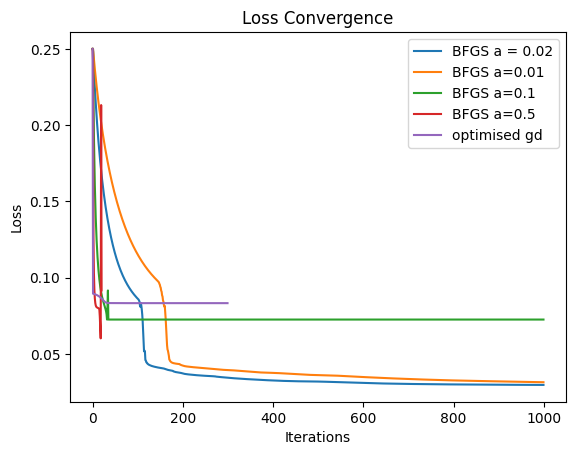

In [47]:
plt.plot(loss_bfgs, label="BFGS a = 0.02")
plt.plot(loss_bfgs2, label="BFGS a=0.01")
plt.plot(loss_bfgs3, label="BFGS a=0.1")
plt.plot(loss_bfgs4, label="BFGS a=0.5")
plt.plot(losses_gd_opt, label = "optimised gd")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.legend()
plt.show()


****IMPORTANT****

This is very good news! This BFGS method - for a very small stepsize - seems to be able to keep decreasing for a very longtime without enecountering NaN's. I spent alot of time playing with it for this to happen. I think the reason that my AdaGrad/GD Descent models get stuck is that the 22 dimensional "descent direction" that is needed to find the ***global min*** is very small and my stepsize is too large. However it takes too long to run the code if I give it a small stepsize. Now that I knwo this I could go back and implement a decreasing stepsize GD to see if that will also converge. Or try a much smaller stepsize GD and run for many many more interations

We can also see that BFGS is sensitive to the stepsize and can be forced to skip some steps if the dot product is too small.

# Q8: Stochastic BFGS

In the same way that for SGD instead of using all f_i to calculate the gradient we sample a subset, we can easily implement the same here.

In [48]:
A = torch.tensor(X_df.values, dtype=torch.float32)
y = torch.tensor(y_df.values, dtype=torch.float32).unsqueeze(1)

def loss_function_batch(x, A_batch, y_batch):
  z = torch.matmul(A_batch, x)
  sigmoid = 1 / (1 + torch.exp(-z))
  loss = ((y_batch - sigmoid) ** 2).mean()
  return loss

def loss_function(x, A, y):
  z = A @ x # shape (n, 1)
  sigmoid = 1.0 / (1.0 + torch.exp(-z))
  loss = ((y - sigmoid)**2).mean()
  return loss


def get_minibatch_loss_and_grad(x, A_batch, y_batch):
    if isinstance(y_batch, np.ndarray):
      y_batch = torch.tensor(y_batch, dtype=torch.float32)

    # Make a fresh leaf tensor so autograd is well-defined
    x_temp = x.detach().clone().requires_grad_(True)

    # Forward pass
    L = f_batch(x_temp, A_batch, y_batch)

    # Backward pass
    L.backward()

    # Grab the gradient
    grad = x_temp.grad.detach().clone()

    return L.item(), grad

def backtracking_line_search(f, x, grad, p, A_batch, y_batch,alpha_init=1.0, rho=0.5, c=1e-4, max_steps=10):
    fval = f(x, A_batch, y_batch).item()

    dot_g_p = torch.dot(grad.view(-1), p.view(-1)).item()

    alpha = alpha_init
    for _ in range(max_steps):
        x_new = x + alpha * p
        f_new = f(x_new, A_batch, y_batch).item()

        #Armijo condition - gives changing stepsize
        if f_new <= fval + c * alpha * dot_g_p:
            return alpha

        alpha *= rho  # Reduce step size

    return alpha  # If not returned earlier, use the final alpha

def stochastic_bfgs(
    A, y, batch_size=32, max_iters=100, alpha_init=1.0, tol=1e-6, verbose=True
):
    """
    Implements Stochastic BFGS Optimization.
    """
    n, d = A.shape

    # Initialize parameters
    x = torch.zeros((d, 1), dtype=torch.float32, requires_grad=True)

    # BFGS Hessian approximation
    H = torch.eye(d, dtype=torch.float32)

    losses = []
    grad_norms = []

    for it in range(max_iters):
        # 1) Sample a mini-batch
        indices = torch.randperm(n)[:batch_size]
        A_batch = A[indices]
        y_batch = y[indices]

        # 2) Compute current loss + grad on mini-batch
        loss_val, grad = get_minibatch_loss_and_grad(x, A_batch, y_batch)
        gnorm = grad.norm().item()

        losses.append(loss_val)
        grad_norms.append(gnorm)

        if verbose and it % 10 == 0:
            print(f"Iter {it}/{max_iters}: loss={loss_val:.4f}, ||grad||={gnorm:.4f}")

        # 3) Check stopping criterion
        if gnorm < tol:
            if verbose:
                print(f"Stopping at iteration {it}, grad norm < {tol}")
            break

        # 4) Compute search direction: p = -H * grad
        p = -H @ grad

        # 5) Backtracking line search for step size alpha
        alpha = backtracking_line_search(
            f=loss_function_batch, x=x, grad=grad, p=p,
            A_batch=A_batch, y_batch=y_batch, alpha_init=alpha_init
        )

        # Compute s = x_{new} - x
        s = alpha * p

        # Update x
        with torch.no_grad():
            x_new = x + s

        # 6) Compute new gradient
        _, grad_new = get_minibatch_loss_and_grad(x_new, A_batch, y_batch)

        # Compute v = grad_{new} - grad
        v = grad_new - grad

        # 7) BFGS Update
        s_dot_v = torch.dot(s.view(-1), v.view(-1))
        if s_dot_v > 1e-12:
            rho = 1.0 / s_dot_v
            I = torch.eye(d, dtype=torch.float32)
            s_col = s.reshape(-1, 1)
            v_col = v.reshape(-1, 1)

            term1 = I - rho * s_col @ v_col.t()
            term2 = I - rho * v_col @ s_col.t()

            H = term1 @ H @ term2 + rho * (s_col @ s_col.t())

        # Prepare for next iteration
        x = x_new.detach().clone().requires_grad_(True)

    return x.detach(), losses, grad_norms

def sgd_batch(
    A, y, batch_size=32, max_iters=100, step_size=1.0, tol=1e-6, verbose=True
):
    """
    Standard mini-batch SGD with fixed step size.
    """
    n, d = A.shape
    x = torch.zeros((d, 1), dtype=torch.float32, requires_grad=True)

    losses = []
    grad_norms = []

    for it in range(max_iters):
        indices = torch.randperm(n)[:batch_size]
        A_batch = A[indices]
        y_batch = y[indices]

        loss_val = loss_function_batch(x, A_batch, y_batch)
        loss_val.backward()

        gnorm = x.grad.norm().item()
        losses.append(loss_val.item())
        grad_norms.append(gnorm)

        if verbose and it % 10 == 0:
            print(f"Iter {it}/{max_iters}: SGD loss={loss_val.item():.4f}, ||grad||={gnorm:.4f}")

        with torch.no_grad():
            x -= step_size * x.grad

        if gnorm < tol:
            if verbose:
                print(f"Stopping at iteration {it}, grad norm < {tol}")
            break

        x.grad.zero_()

    return x.detach(), losses, grad_norms

if __name__ == "__main__":

    n, d = A.shape
    nb_iters = 500
    batch_size = n // 2
    step_size = 60

    print("\n=== Running Stochastic BFGS ===")
    x_bfgs, losses_BFGS_stochastic, gradnorms_BFGS_stochastic = stochastic_bfgs(
        A, y, batch_size=batch_size, max_iters=nb_iters,
        alpha_init=1.0, tol=1e-6, verbose=True
    )

    print("\n=== Running Mini-batch SGD ===")
    x_sgd, losses_sgd, gradnorms_sgd = sgd_batch(
        A, y, batch_size=batch_size, max_iters=nb_iters,
        step_size=step_size, tol=1e-6, verbose=True
    )

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.semilogy(losses_sgd, label="SGD (Batch)")
    plt.semilogy(losses_BFGS_stochastic, label="Stochastic BFGS (Batch)")
    plt.xlabel("Iterations")
    plt.ylabel("Loss (log scale)")
    plt.title("Stochastic Gradient Methods: SGD vs BFGS (Loss)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Gradient Norm
    plt.figure(figsize=(10, 6))
    plt.semilogy(gradnorms_sgd, label="SGD Grad Norm")
    plt.semilogy(gradnorms_BFGS_stochastic, label="BFGS Grad Norm")
    plt.xlabel("Iterations")
    plt.ylabel("Gradient Norm (log scale)")
    plt.title("Stochastic Gradient Methods: SGD vs BFGS (Gradient Norm)")
    plt.legend()
    plt.grid(True)
    plt.show()



=== Running Stochastic BFGS ===


NameError: name 'f_batch' is not defined

I found that Stochastic BFGS with a constant step rate was very unstable and would almost always stop quickly due to the gradients being very small so here I have implemented a method that reduces the stepsize.

We see that the performance of the 2 methods are very similar

# Q9 - Discuss Stochastic bfgs + Adagrad

In terms of **DATA POINTS**


*   BFGS - have to calculate the stochastic gradiant twice every iteration once at x_k, and once at x_k+1, there is perhaps a more efficient implementation that stores radient at x_k+1 and uses it as x_k in the following round - although this would also use 2 different batches which means the total number of points accessed is still constant and = 2* batch size.
*  AdaGrad - only 1 call of grad per iteration

In terms of **d-dim vectors** updated:

*   BFGS - more intensive has to maintain, store and access a d*d Matrix each round, as well as having to calculate, s,v and x.
*   Adagrad - only  requires the updatin of 3 vectors, so Adagrad should be faster

# **Q10: BFGS and Proximal Methods Applied To The Regularised Problem 3**

Here we aim to merge the BFGS method with ISTA. We do this by following the BFGS method to propose a new $x_{k+1}$ and then we apply the proximal operator for the 1 norm as writtten in the question earlier for each element in the vector.

In [ ]:
def soft_thresholding(x, lbda):
    return torch.sign(x) * torch.clamp(torch.abs(x) - lbda, min=0.0)


In [ ]:
def proximal_bfgs_minimize(f, x_init, lbda, alpha,  max_iters, tol):
    d = x_init.shape[0]  # Dimension
    x = x_init.clone().detach().requires_grad_(True)
    H = torch.eye(d)  # Initialize Hessian approximation as identity
    losses = []

    def get_grad(x):
        """Compute gradient using PyTorch autograd."""
        x_temp = x.clone().detach().requires_grad_(True)
        loss = f(x_temp)
        loss.backward()
        return x_temp.grad, loss.item()

    for k in range(max_iters):
        grad_k, loss_k = get_grad(x)
        losses.append(loss_k)

        if grad_k.norm() < tol:
            print(f"Converged at iteration {k}")
            break

        # Compute BFGS search direction
        p_k = -H @ grad_k


        # Compute next iterate (Gradient step)
        x_new = x + alpha * p_k

        # Apply ISTA Soft-thresholding for L1 Regularization
        x_new = soft_thresholding(x_new, lbda * alpha)

        # Compute new gradient
        grad_kplus1, loss_kplus1 = get_grad(x_new)
        s_k = x_new - x
        v_k = grad_kplus1 - grad_k

        # Convert to 1D tensors for torch.outer()
        s_k_flat = s_k.view(-1)  # Convert (d,1) → (d,)
        v_k_flat = v_k.view(-1)  # Convert (d,1) → (d,)

        # Compute dot product correctly
        s_dot_v = torch.dot(s_k_flat, v_k_flat).item()

        # BFGS update only if curvature condition holds
        if s_dot_v > 1e-12:
            rho_k = 1.0 / s_dot_v
            I = torch.eye(d)
            term1 = I - rho_k * torch.outer(s_k_flat, v_k_flat)
            term2 = I - rho_k * torch.outer(v_k_flat, s_k_flat)
            H = term1 @ H @ term2 + rho_k * torch.outer(s_k_flat, s_k_flat)

        x = x_new  # Update x

        if (k + 1) % 10 == 0:
            print(f"Iteration {k+1}, Loss: {loss_kplus1:.6f}")

    return x, losses


def fun10(x):
        x = x.view(-1, 1)  # Ensure x is (d, 1)
        z = X_tensor @ x  # Compute Ax
        sigmoid = 1 / (1 + torch.exp(-z))  # Compute sigmoid
        loss_per_sample = (y_tensor - sigmoid) ** 2  # Elementwise squared error
        return loss_per_sample.mean()  # Return mean loss

# Run Proximal BFGS with ISTA thresholding

x_proxbfgs_1, losses_proxbfgs_1 = proximal_bfgs_minimize(fun10, x0, 0.001, 1, 100, 10e-6)
x_proxbfgs_2, losses_proxbfgs_2 = proximal_bfgs_minimize(fun10, x0, 0.002, 1, 100, 10e-6)
x_proxbfgs_3, losses_proxbfgs_3 = proximal_bfgs_minimize(fun10, x0, 0.01, 1, 100, 10e-6)
x_proxbfgs_4, losses_proxbfgs_4 = proximal_bfgs_minimize(fun10, x0, 0.05, 1, 100, 10e-6)



plt.plot(losses_proxbfgs_1, color = "red")
plt.plot(losses_proxbfgs_2, color = "blue")
plt.plot(losses_proxbfgs_3, color = "green")
plt.plot(losses_proxbfgs_4, color = "orange")
plt.title("proximal bfgs loss for varying stepsize")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


In [ ]:
x_proxbfgs_5, losses_proxbfgs_5 = proximal_bfgs_minimize(fun10, x0, 0.001, 0.02, 300, 10e-6)
plt.plot(losses_proxbfgs_5, color = "red")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("proximal bfgs loss stepsize = 0.02, lbda = 0.001")
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))

# Define colors for different lambda values
colors = ["blue", "orange", "green", "red", "purple"]

# Plot Loss Convergence for Different Lambda Values
plt.subplot(1, 2, 1)
plt.plot(losses_adagradista1, label="prox adagrad λ = 0.1", linewidth=2, color=colors[0])
plt.plot(losses_adagradista2, label="prox adagrad λ = 0.05", linewidth=2, color=colors[1])
plt.plot(losses_adagradista3, label="prox adagrad λ = 0.01", linewidth=2, color=colors[2])
plt.plot(losses_adagradista4, label="prox adagrad λ = 0.009", linewidth=2, color=colors[3])
plt.plot(losses_adagradista5, label="prox adagrad λ = 0.005", linewidth=2, color=colors[4])
plt.plot(losses_proxbfgs_5, color = "cyan", label = "proxbfgs lmbda = 0.01")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Convergence for Different λ Values", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

In [ ]:
x_proxbfgs_6, losses_proxbfgs_6 = proximal_bfgs_minimize(fun10, x0, 0.001, 0.02, 100, 10e-6)
plt.plot(losses_proxbfgs_6, color = "red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

Proximal BFGS is advantageous compared to Adagrad as it seems to be able to achieve a lower objective value if we compare the scores for the same lambdas.

# Q11: LBFGS vs BFGS

In [ ]:
def f(x, A, y):
    x_2d = x.view(-1, 1)  # Ensure shape (d,1)
    z = A @ x_2d
    sigmoid = 1.0 / (1.0 + torch.exp(-z))  # Ensure torch.exp() is accessible
    return ((y - sigmoid) ** 2).mean()



def L_BFGS(
    f, A, y,
    alpha,  # Step size
    m,        # Memory for L-BFGS
    max_iters,  # Maximum iterations
    tol   # Tolerance for stopping condition
):


    n, d = A.shape


    x = torch.zeros(d, dtype=torch.float32)


    s_list = []
    v_list = []


    def get_grad(x_vec):
        x_tmp = x_vec.detach().clone().requires_grad_(True)
        loss_value = f(x_tmp, A, y)
        loss_value.backward()
        return x_tmp.grad.detach(), loss_value.item()

    # Track losses and gradient norms
    losses = []
    grad_norms = []

    for k in range(max_iters):
        # 1) Compute current gradient and loss
        grad_k, loss_k = get_grad(x)
        losses.append(loss_k)
        gnorm = grad_k.norm().item()
        grad_norms.append(gnorm)

        # Check stopping criterion
        if gnorm < tol:
            print(f"[L-BFGS] Stopped at iteration {k}: ||grad||={gnorm:.2e} < {tol}")
            break

        # 2) L-BFGS Two-Loop Recursion
        q = grad_k.clone()
        alpha_vals = []

        # First loop: from last to first stored update
        for (s_i, v_i) in reversed(list(zip(s_list, v_list))):
            denom = s_i.dot(v_i)
            alpha_i = 0.0
            if abs(denom.item()) > 1e-12:  # Prevent division by zero
                alpha_i = s_i.dot(q).item() / denom.item()
            alpha_vals.append(alpha_i)
            q -= alpha_i * v_i

        # Estimate initial Hessian scale gamma_k
        if len(s_list) > 0:
            denom_g = v_list[-1].dot(v_list[-1]).item()
            gamma_k = 1.0 if denom_g < 1e-12 else s_list[-1].dot(v_list[-1]).item() / denom_g
        else:
            gamma_k = 1.0  # Default if no history

        z = gamma_k * q
        alpha_vals.reverse()

        # Second loop: bottom up
        for i, (s_i, v_i) in enumerate(zip(s_list, v_list)):
            denom = s_i.dot(v_i)
            beta_i = 0.0
            if abs(denom.item()) > 1e-12:  # Prevent division by zero
                beta_i = v_i.dot(z).item() / denom.item()
            alpha_i = alpha_vals[i]
            z += (alpha_i - beta_i) * s_i

        # Compute search direction
        direction_k = -z

        # 3) Update x
        x_new = x + alpha * direction_k

        # 4) Compute new gradient info
        grad_kplus1, _ = get_grad(x_new)
        s_k = x_new - x
        v_k = grad_kplus1 - grad_k

        # 5) Store (s_k, v_k) if s_k^T v_k > 0 (Curvature Condition)
        if s_k.dot(v_k) > 1e-12:
            s_list.append(s_k.clone())
            v_list.append(v_k.clone())

            # Maintain memory limit (forget oldest update)
            if len(s_list) > m:
                s_list.pop(0)
                v_list.pop(0)

        # Move to the next iteration
        x = x_new

        # Optional print statement for every 10 iterations
        if (k + 1) % 10 == 0:
            print(f"[L-BFGS:m={m}] it={k+1}, loss={loss_k:.6f}, ||grad||={gnorm:.2e}")

    return x, losses, grad_norms


In [ ]:
x_lbfgs_1, loss_lbfgs_1, grad_norms_lbfgs1 = L_BFGS(f, X_tensor, y_tensor, alpha = 1, m = 10, tol = 1e-6, max_iters=50)
x_lbfgs_2, loss_lbfgs_2, grad_norms_lbfgs2 = L_BFGS(f, X_tensor, y_tensor, alpha = 1, m=5, tol = 1e-6, max_iters = 50)
x_lbfgs_3, loss_lbfgs_3, grad_norms_lbfgs3 = L_BFGS(f, X_tensor, y_tensor, alpha = 1, m=0, tol=1e-6, max_iters = 50)


In [ ]:
print(x_lbfgs_1)
print(x_lbfgs_2)
print(x_lbfgs_3)

In [ ]:
plt.semilogy(loss_lbfgs_1, color = "red", label = "m=10")
plt.semilogy(loss_lbfgs_2, color = "blue", label = "m=5")
plt.semilogy(loss_lbfgs_3, color = "green", label = "m=0")
plt.plot(loss_bfgs, label="BFGS")
plt.plot(losses_gd_opt, label = "optimised gd")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("L-BFGS Loss for varying m")
plt.legend()
plt.show()

***Question Compare L-BFGS and deterministic BFGS***

In my implementation the simple BFGS method was the most suceessful buy far getting to within a 10^-3 distance, and it was also the fastest algorithm by far.This is surprising because the whole point of L-BFGS is that it requires the stotrage of less elements than BFGS, as it relies only on m past iterates, the memory complexity of BFGS is O(d^2), and is only O(md) for LBFGS. I think it is slower because there is an extra calculation step in the LBFGS compared to BFGS and this is chat is slow for the computer more than the size of the data. This is why the L-BFGS only ran for 100 iterations.

We did not obtain any difference between using 10 or 5 = m, however taking m=0 gives a smooth curve. However there is a noticable difference in the time it takes to run these codes with 10 being the slowest and 0 being the fastest

I think that maybe I was lucky (havong tried many many times) to have fallen upon an x0 and a learning rate for BFGS that allows it to converge as well as it does and that the same sufficient parameters should also exist for L-BFGS, because it is written in a few papers: https://arxiv.org/pdf/1704.00116, https://proceedings.mlr.press/v51/moritz16.pdf on variants of L BFGS that it should outperform BFGS especially in the high dimensional setting.

***Effect of stepsize***

In [ ]:
x_lbfgs_5, loss_lbfgs_5, grad_norms_lbfgs5 = L_BFGS(f, X_tensor, y_tensor, alpha = 100, m = 0, tol = 1e-6, max_iters = 500)
x_lbfgs_6, loss_lbfgs_6, grad_norms_lbfgs6 = L_BFGS(f, X_tensor, y_tensor, alpha = 50, m = 0, tol = 1e-6, max_iters = 500)
x_lbfgs_7, loss_lbfgs_7, grad_norms_lbfgs7 = L_BFGS(f, X_tensor, y_tensor, alpha = 1, m = 0, tol = 1e-6, max_iters = 500)
x_lbfgs_8, loss_lbfgs_8, grad_norms_lbfgs8 = L_BFGS(f, X_tensor, y_tensor, alpha = 75, m = 0, tol = 1e-6, max_iters = 500)
x_lbfgs_9, loss_lbfgs_9, grad_norms_lbfgs9 = L_BFGS(f, X_tensor, y_tensor, alpha = 40, m = 0, tol = 1e-6, max_iters = 500)
x_lbfgs_10, loss_lbfgs_10, grad_norms_lbfgs10 = L_BFGS(f, X_tensor, y_tensor, alpha = 30, m = 0, tol = 1e-6, max_iters = 500)

In [ ]:
plt.semilogy(loss_lbfgs_5, color = "red", label = "alpha = 100")
plt.semilogy(loss_lbfgs_6, color = "blue", label = "alpha = 50")
plt.semilogy(loss_lbfgs_7, color = "green", label = "alpha = 1")
plt.semilogy(loss_lbfgs_8, color = "orange", label = "alpha = 75")
plt.semilogy(loss_lbfgs_9, color = "purple", label = "alpha = 40")
plt.semilogy(loss_lbfgs_10, color = "black", label = "alpha = 30")
plt.semilogy(loss_bfgs, label="*optimal BFGS")
#plt.plot(losses_gd_opt, label = "optimised gd")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("L-BFGS Loss for varying stepsize")
plt.legend()
plt.show()

***Update: BFGS vs LBFGS (2)***

Whilst investigating the stability of the method wrt stepsize and memory span I found firstly that for m=0 the algorithm is extremely fast - I can run 2000 iterations in seconds and more importantly that it seems to contininue to decrease without reaching a 0 gradient error. The L BFGS method is more stable than the BFGS because whist running BFGS after c.1500 iterations I started to get "RunTime 0 gradient errors" whereas this method can keep running. Furthermore with a large stepsize the method converges very quickly, I think the best improvement to this method, since it requires a large stepsize at first to converge quickly would be to implement an adaptive stepsize, as a large constant stepsize at small values probably means the iterations are bouning around a small area unable to go down any more due to the stepsize. .

# ***Q12 Stochastic L BFGS***

Since this paper: https://arxiv.org/pdf/1704.00116 aims to introduce a nonuniformly sampled stochastic L BFGS algorithm, I will replace BFGS by LBFGS in Q8 and implement a stochastic LBFGS method as done before.

In [ ]:
import torch

def stochastic_L_BFGS(
    f, A, y,
    alpha,  # Step size
    m,      # Memory for L-BFGS
    max_iters,  # Maximum iterations
    tol,    # Tolerance for stopping condition
    batch_size  # Mini-batch size for stochastic updates
):
    """
    Stochastic L-BFGS optimization with mini-batch gradient estimation.

    Args:
        f: Function to minimize.
        A: Feature matrix (n, d).
        y: Target vector (n, 1).
        alpha: Step size.
        m: Number of stored past updates (L-BFGS memory size).
        max_iters: Maximum iterations.
        tol: Tolerance for stopping condition.
        batch_size: Size of mini-batch for stochastic gradient updates.

    Returns:
        x: Optimized parameter vector.
        losses: List of loss values per iteration.
        grad_norms: List of gradient norms per iteration.
    """
    # Get problem dimensions
    n, d = A.shape

    # Initialize x (shape (d,))
    x = torch.zeros(d, dtype=torch.float32)

    # L-BFGS memory
    s_list = []
    v_list = []

    # Function to compute gradient and loss on a mini-batch
    def get_grad(x_vec, batch_indices):
        """
        Computes the gradient and loss for a mini-batch.
        """
        A_batch = A[batch_indices]
        y_batch = y[batch_indices]

        x_tmp = x_vec.detach().clone().requires_grad_(True)
        loss_value = f(x_tmp, A_batch, y_batch)
        loss_value.backward()
        return x_tmp.grad.detach(), loss_value.item()

    # Track losses and gradient norms
    losses = []
    grad_norms = []

    for k in range(max_iters):
        # 1) Sample a random mini-batch
        batch_indices = torch.randperm(n)[:batch_size]  # Randomly select batch indices

        # 2) Compute current gradient and loss using the mini-batch
        grad_k, loss_k = get_grad(x, batch_indices)
        losses.append(loss_k)
        gnorm = grad_k.norm().item()
        grad_norms.append(gnorm)

        # Check stopping criterion
        if gnorm < tol:
            print(f"[Stochastic L-BFGS] Stopped at iteration {k}: ||grad||={gnorm:.2e} < {tol}")
            break

        # 3) L-BFGS Two-Loop Recursion
        q = grad_k.clone()
        alpha_vals = []

        # First loop: from last to first stored update
        for (s_i, v_i) in reversed(list(zip(s_list, v_list))):
            denom = s_i.dot(v_i)
            alpha_i = 0.0
            if abs(denom.item()) > 1e-12:  # Prevent division by zero
                alpha_i = s_i.dot(q).item() / denom.item()
            alpha_vals.append(alpha_i)
            q -= alpha_i * v_i

        # Estimate initial Hessian scale gamma_k
        if len(s_list) > 0:
            denom_g = v_list[-1].dot(v_list[-1]).item()
            gamma_k = 1.0 if denom_g < 1e-12 else s_list[-1].dot(v_list[-1]).item() / denom_g
        else:
            gamma_k = 1.0  # Default if no history

        z = gamma_k * q
        alpha_vals.reverse()

        # Second loop: bottom up
        for i, (s_i, v_i) in enumerate(zip(s_list, v_list)):
            denom = s_i.dot(v_i)
            beta_i = 0.0
            if abs(denom.item()) > 1e-12:  # Prevent division by zero
                beta_i = v_i.dot(z).item() / denom.item()
            alpha_i = alpha_vals[i]
            z += (alpha_i - beta_i) * s_i

        # Compute search direction
        direction_k = -z

        # 4) Update x
        x_new = x + alpha * direction_k

        # 5) Compute new gradient info using a new mini-batch
        batch_indices = torch.randperm(n)[:batch_size]  # Get new mini-batch
        grad_kplus1, _ = get_grad(x_new, batch_indices)
        s_k = x_new - x
        v_k = grad_kplus1 - grad_k

        # 6) Store (s_k, v_k) if s_k^T v_k > 0 (Curvature Condition)
        if s_k.dot(v_k) > 1e-12:
            s_list.append(s_k.clone())
            v_list.append(v_k.clone())

            # Maintain memory limit (forget oldest update)
            if len(s_list) > m:
                s_list.pop(0)
                v_list.pop(0)

        # Move to the next iteration
        x = x_new

        # Optional print statement for every 10 iterations
        if (k + 1) % 10 == 0:
            print(f"[Stochastic L-BFGS:m={m}] it={k+1}, loss={loss_k:.6f}, ||grad||={gnorm:.2e}")

    return x, losses, grad_norms


***Stepsize and Stochastic LBFGS***

In [ ]:
A = torch.tensor(X_df.values, dtype=torch.float32)
y_0 = torch.tensor(y_df.values, dtype=torch.float32).unsqueeze(1)

# Run Stochastic L-BFGS
x_sto_lbfgs_1, losses_sto_lbfgs_1, grad_norms_sto_lbfgs_1 = stochastic_L_BFGS(
    f=f, A=A, y=y_0,
    alpha=10, m=0, max_iters=500, tol=1e-6,
    batch_size=1000  # Mini-batch size
)

x_sto_lbfgs_2, losses_sto_lbfgs_2, grad_norms_sto_lbfgs = stochastic_L_BFGS(
    f=f, A=A, y=y_0,
    alpha=5, m=0, max_iters=500, tol=1e-6,
    batch_size=1000
)
x_sto_lbfgs_3, losses_sto_lbfgs_3, grad_norms_sto_lbfgs_3 = stochastic_L_BFGS(
    f=f, A=A, y=y_0,
    alpha=0.1, m=0, max_iters=500, tol=1e-6,
    batch_size=1000
)

# Print final results
#print("\nFinal Loss:", losses)
#print("Final Gradient Norm:", grad_norms)
#print("Final x values:", x_final)

In [ ]:
plt.plot(losses_sto_lbfgs_1, label="Stochastic L-BFGS, a =10, m=0")
plt.plot(losses_sto_lbfgs_2, label="Stochastic L-BFGS, a =5, m=0")
plt.plot(losses_sto_lbfgs_3, label="Stochastic L-BFGS, a =0.1, m=0")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Stochastic L-BFGS Loss")
plt.legend()
plt.show()

***Compare to SGD as in Q8***

In [ ]:
plt.plot(losses_sto_lbfgs_1, label="Stochastic L-BFGS, a =10, m=0")
plt.plot(losses_sto_lbfgs_2, label="Stochastic L-BFGS, a =5, m=0")
plt.plot(losses_sto_lbfgs_3, label="Stochastic L-BFGS, a =0.1, m=0")
plt.plot(losses_sgd_compar, label = "*optimal SGD for comparison")
plt.plot(loss_lbfgs_8[:500], label = "Vanilla LBFGS algo")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Stochastic L-BFGS Loss vs *Optimal SGD")
plt.legend()
plt.show()

We see that the Optimal SGD found in Q4 manages to get closer to 0 than the stochastic methods for the sets of hyperparameteres chosen, howeer it gets less close than the Vanilla LBFGS ALgorithm. The 2 main aims of stochastic descent methods are to introduce exploration and alleviate compuational complexity. However, since our LBFGS algorithm is already very fast when m=0 there is very little interest in using any other method since it both the fastest and best minimising method.

In conclusion the method that worked the best for me was the LBFGS as it reached the lowest objective value, and was fast to implement for m = 0, and is easy to introduce stochastic/proximal variants. Although our objective is not convex it is smooth and as such, given that LBFGS, SGD and BFGS were able to get very close to 0 loss, there should be ways given enough iterations and precision, to make Adagrad and GD also get closer however I was unable to find it. I think partly I am limited by computing power, although introducing a momentum GD may potentially have helped GD to move out from the plateau it was stuck on. Another method we could try is by adding a random noise or a decreasing step size when we see them become stationary.